# Compare CDDM and PSPA in Ser/Thr kinases

## Setup

In [ ]:
#!pip install git+https://github.com/sky1ove/katlas.git -q

In [ ]:
from katlas.imports import *
import os, seaborn as sns

from fastbook import *
from scipy.stats import spearmanr, pearsonr

from PIL import Image
from tqdm import tqdm

set_sns()

## Load data

In [ ]:
df = Data.get_ks_dataset()
df['SUB'] = df.substrate.str.upper()

## Get overlap kinase

In [ ]:
# normalized PSPA data
norm = pd.read_csv('raw/pspa_st_norm.csv')
raw = pd.read_csv('raw/pspa_st_raw.csv')

In [ ]:
#get overlap and count
overlap_cnt = df[df.kinase_paper.isin(raw.kinase)].kinase_paper.value_counts()

In [ ]:
overlap_cnt

PKACA     1740
ERK2      1380
CDK1      1325
IKKB      1297
ERK1      1160
          ... 
IRE1         1
CK1A2        1
HUNK         1
CAMK1G       1
DRAK1        1
Name: kinase_paper, Length: 286, dtype: int64

In [ ]:
overlap_cnt = overlap_cnt[overlap_cnt>100]

In [ ]:
overlap_cnt

PKACA    1740
ERK2     1380
CDK1     1325
IKKB     1297
ERK1     1160
         ... 
HIPK3     110
CDK8      107
BUB1      106
MEKK3     104
GRK1      101
Name: kinase_paper, Length: 202, dtype: int64

In [ ]:
# PSPA data
raw = raw.set_index('kinase')
norm = norm.set_index('kinase')

## Plot

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

In [ ]:
# aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
aa_order_paper = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
# position = [i for i in range(-7,8)]
position_paper = [-5,-4,-3,-2,-1,1,2,3,4]

### Dataset-driven vs. normalized

To generate all of other figures and save them, uncheck plt.savefig, and comment out plt.show()

In [ ]:
set_sns()

  0%|          | 0/202 [00:00<?, ?it/s]

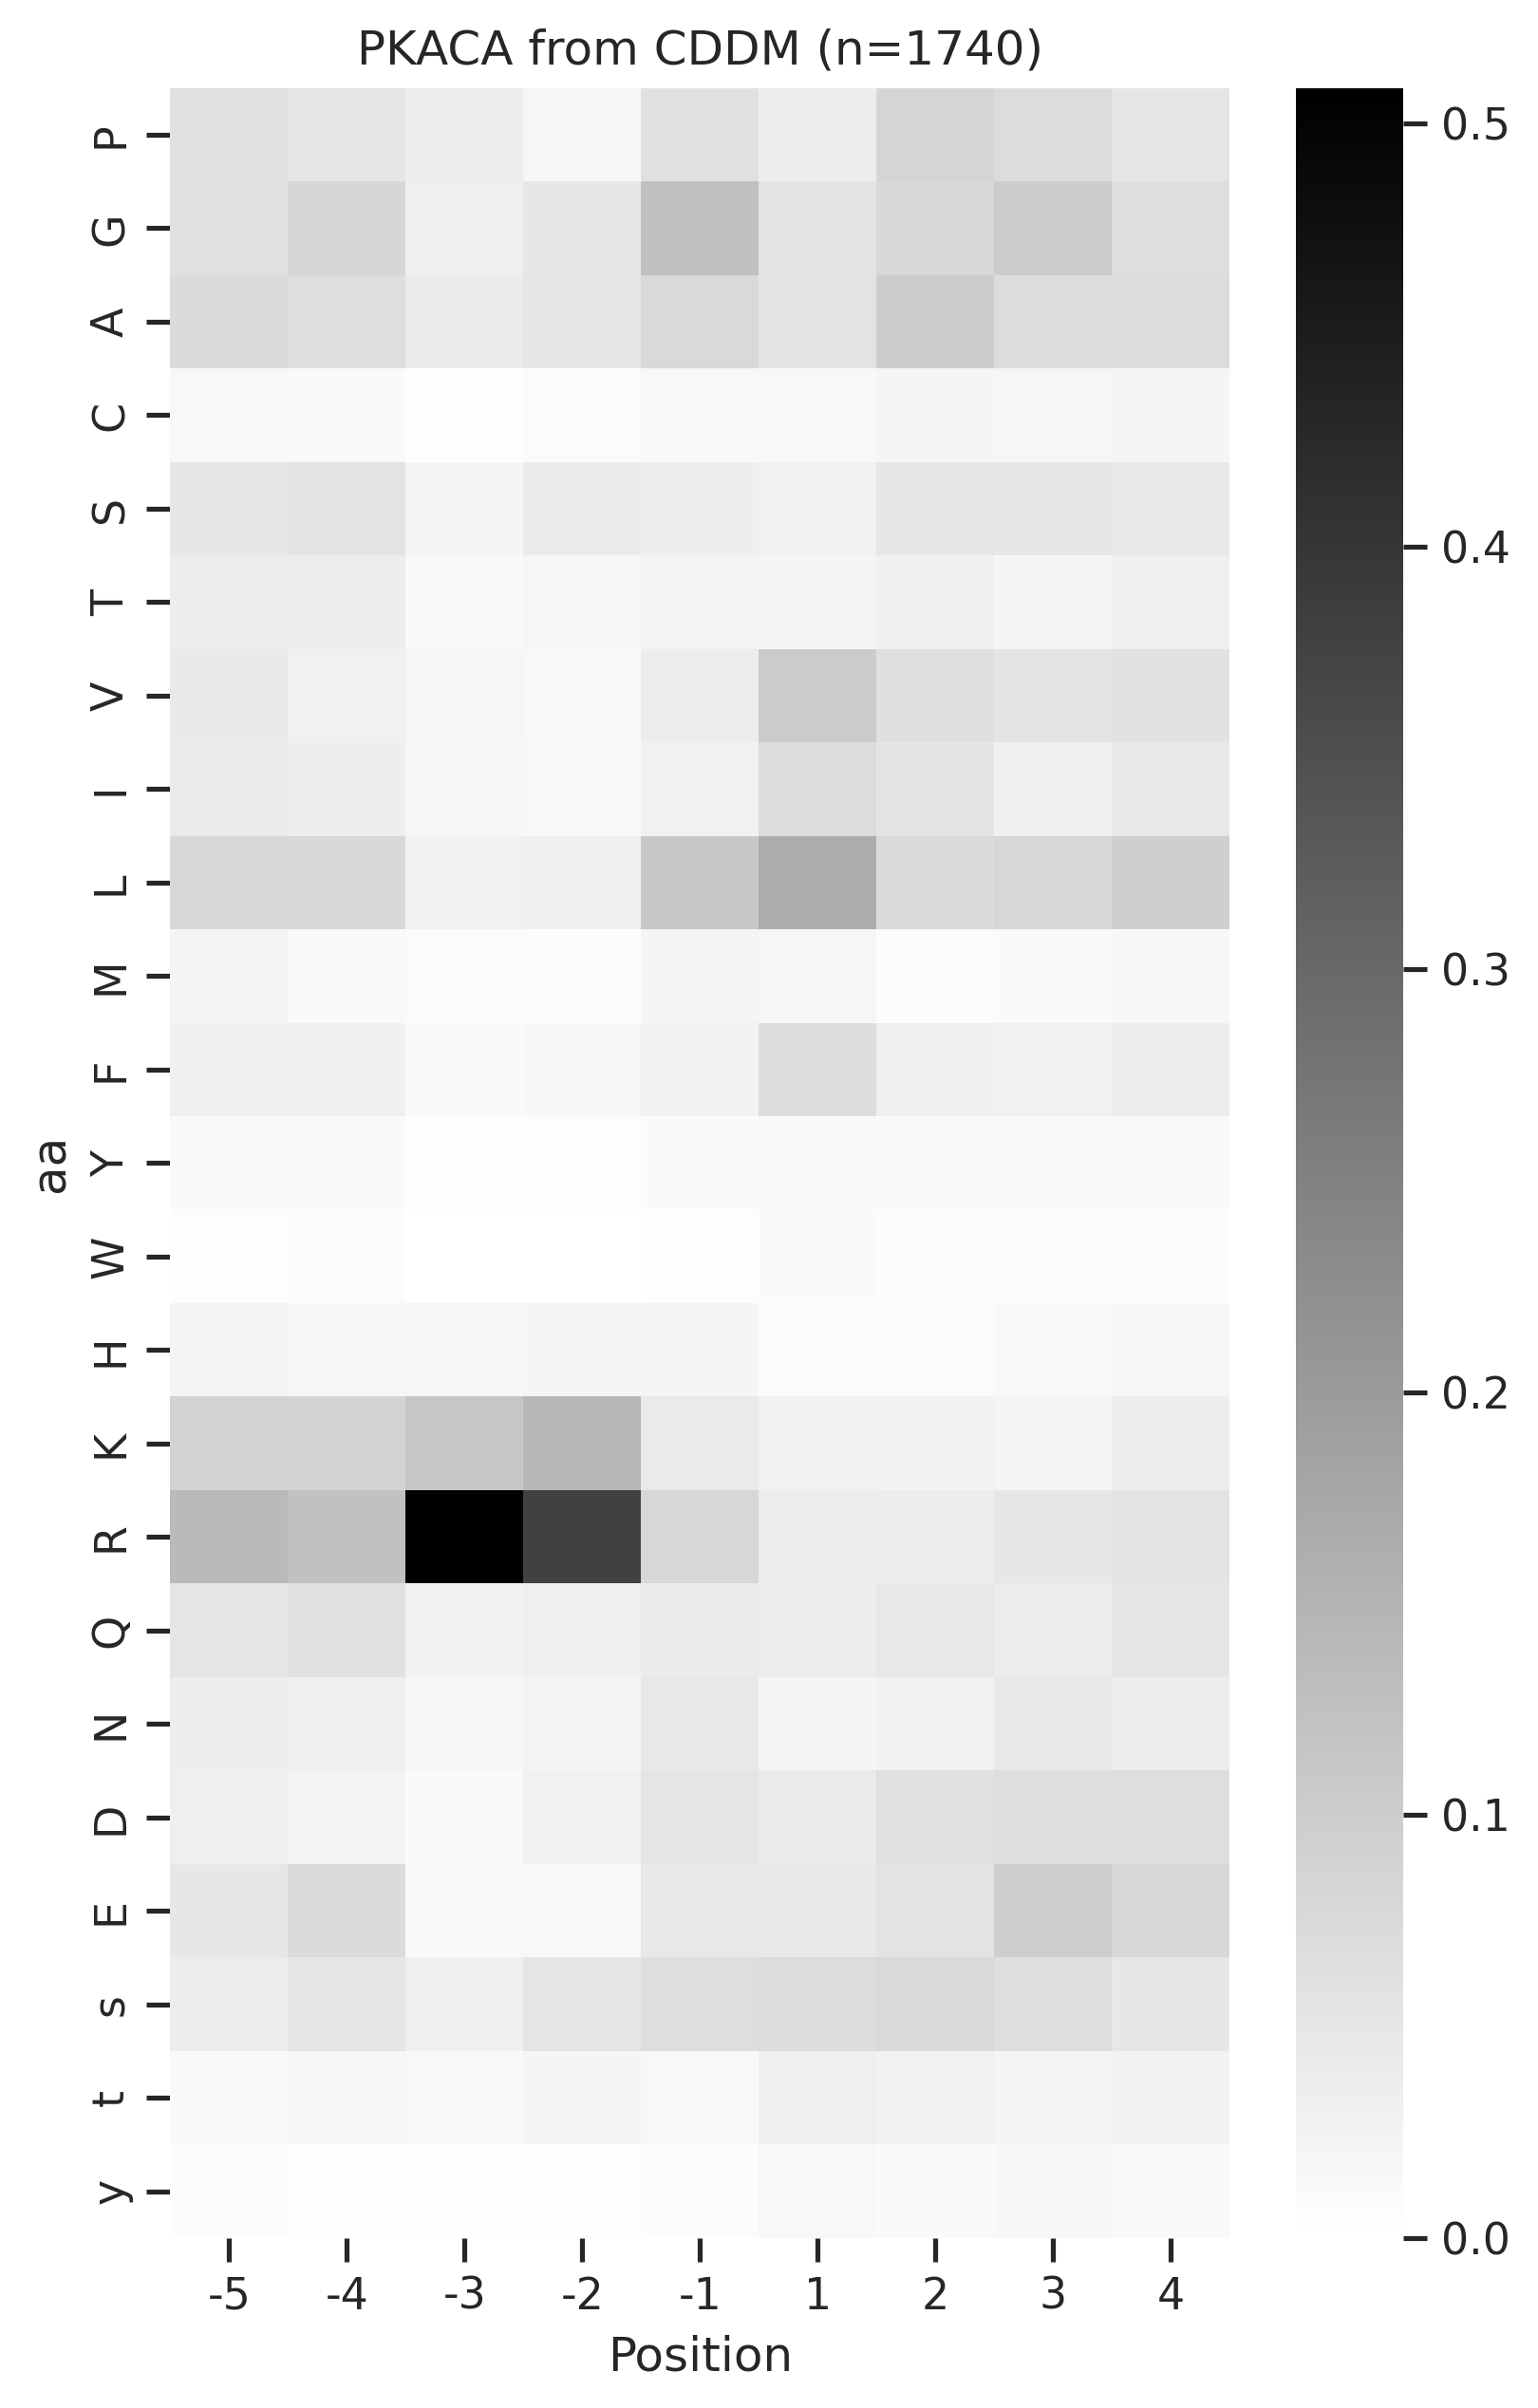

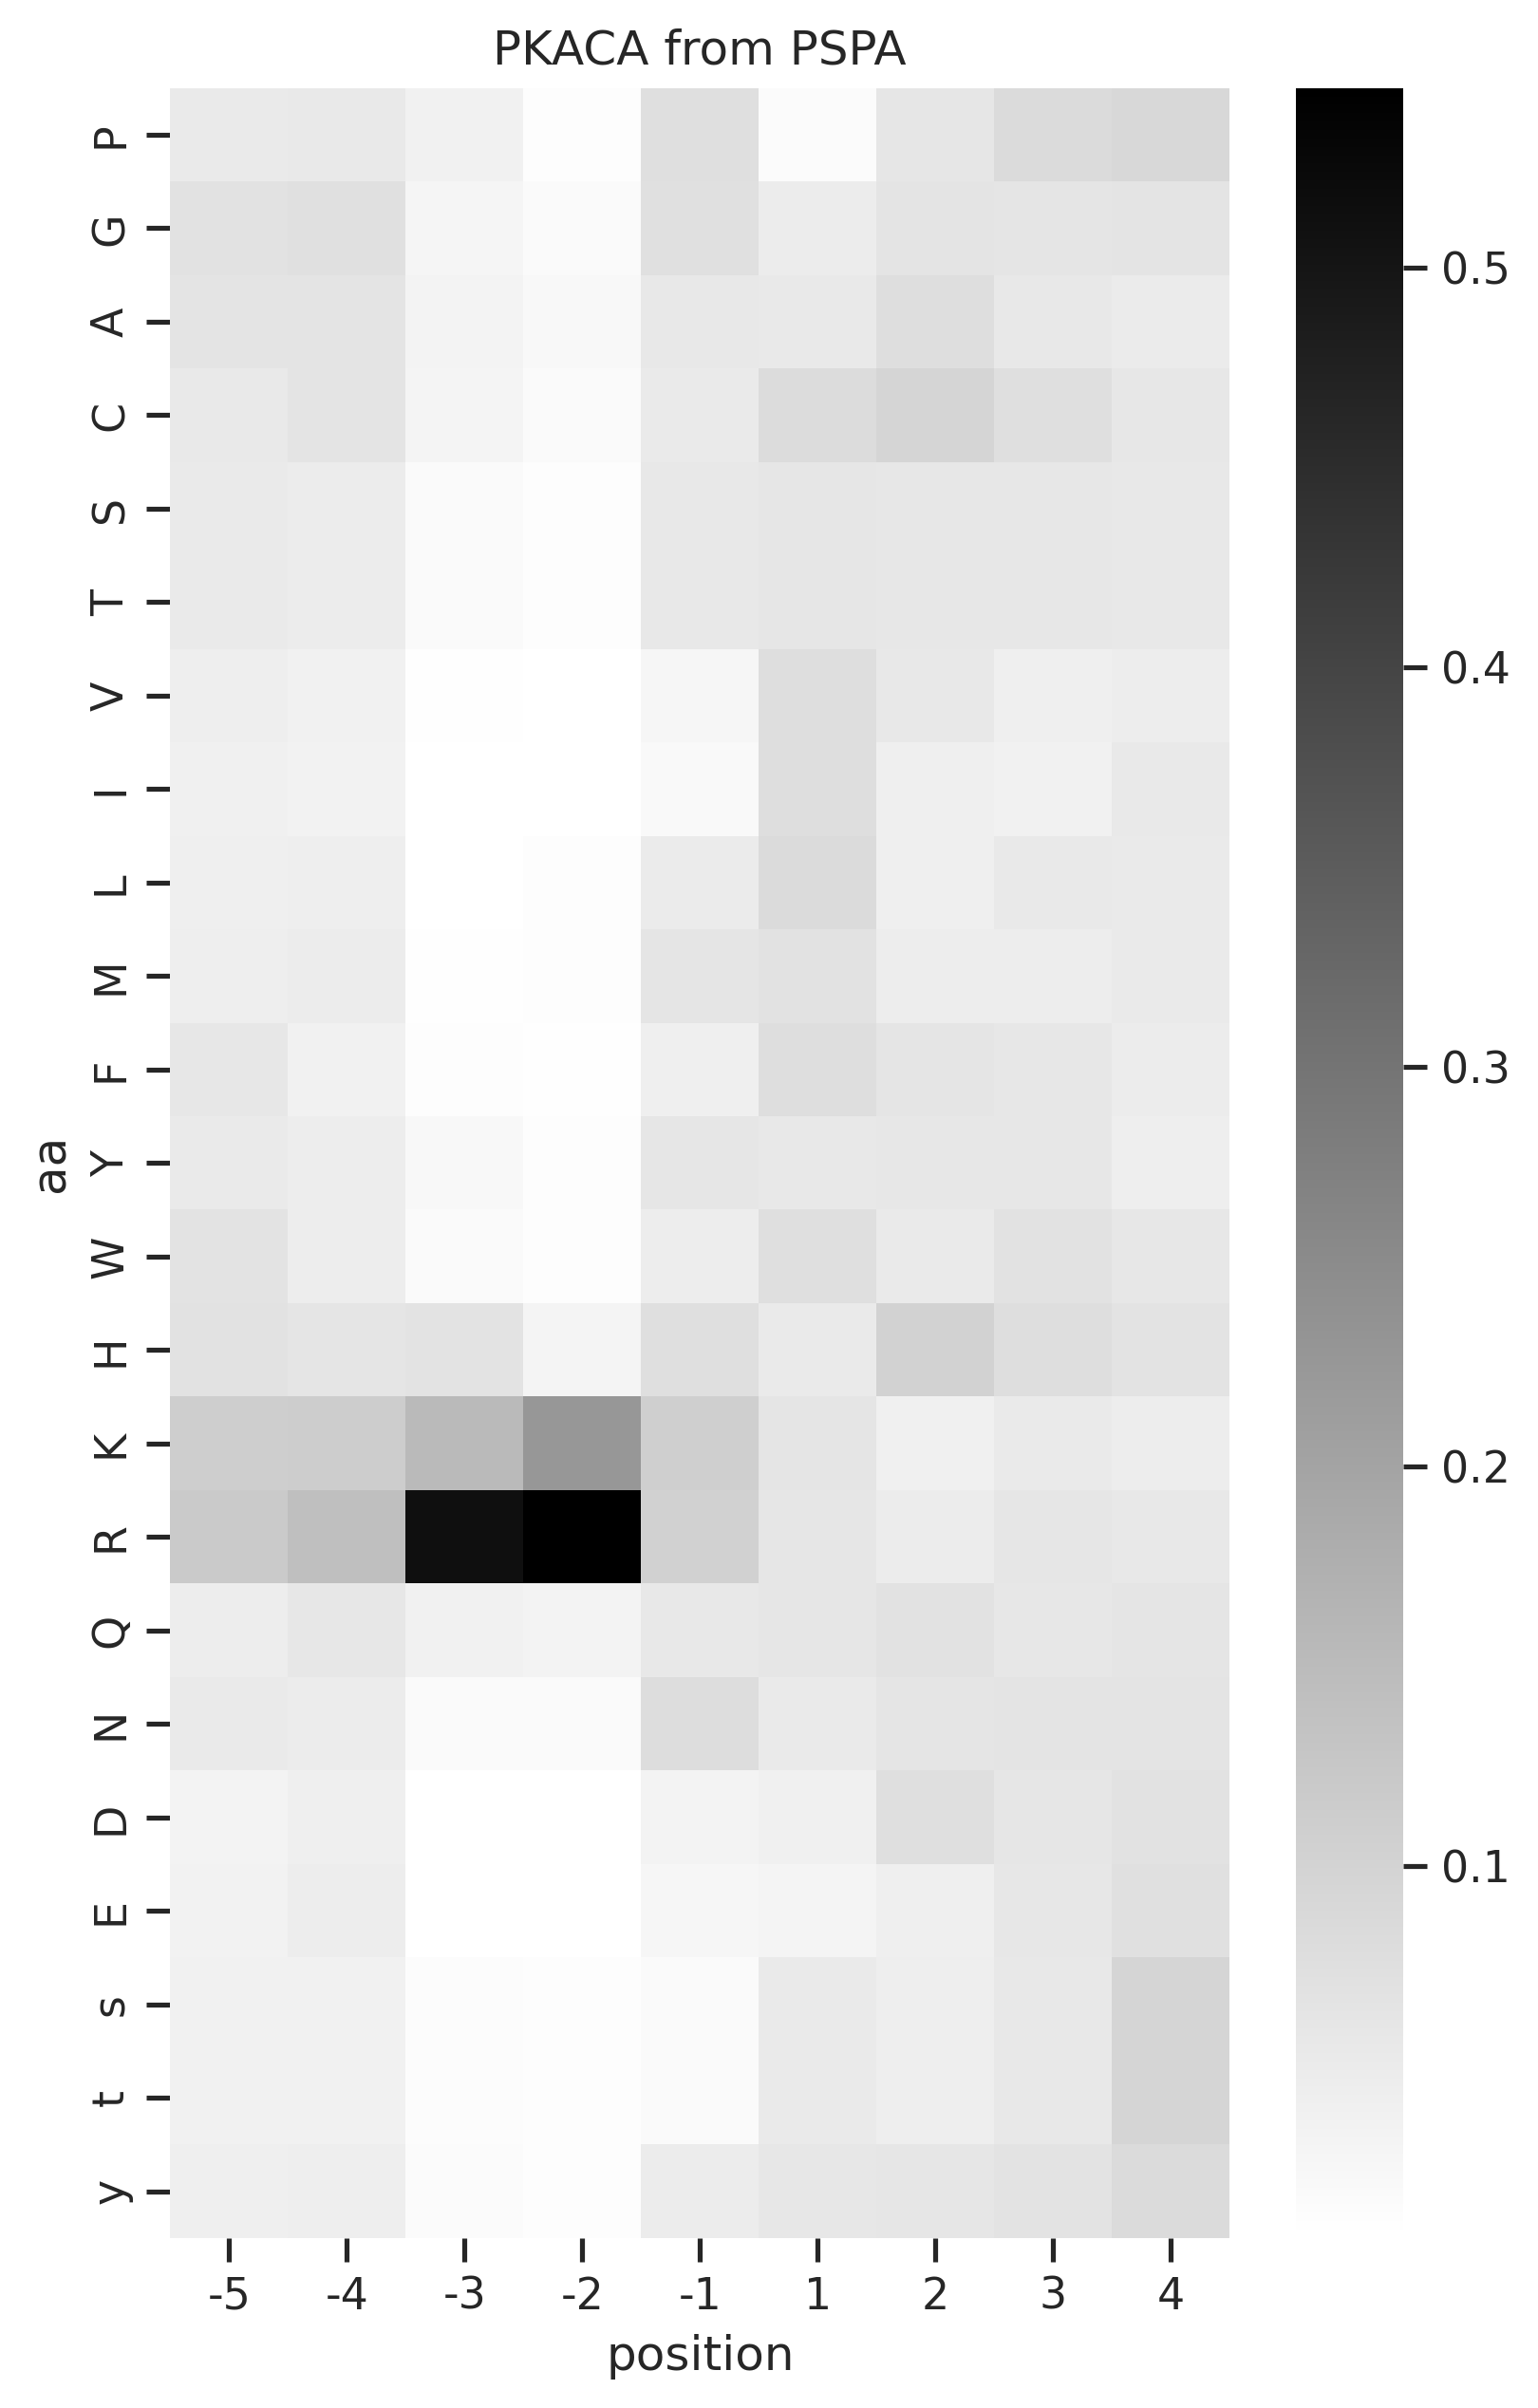

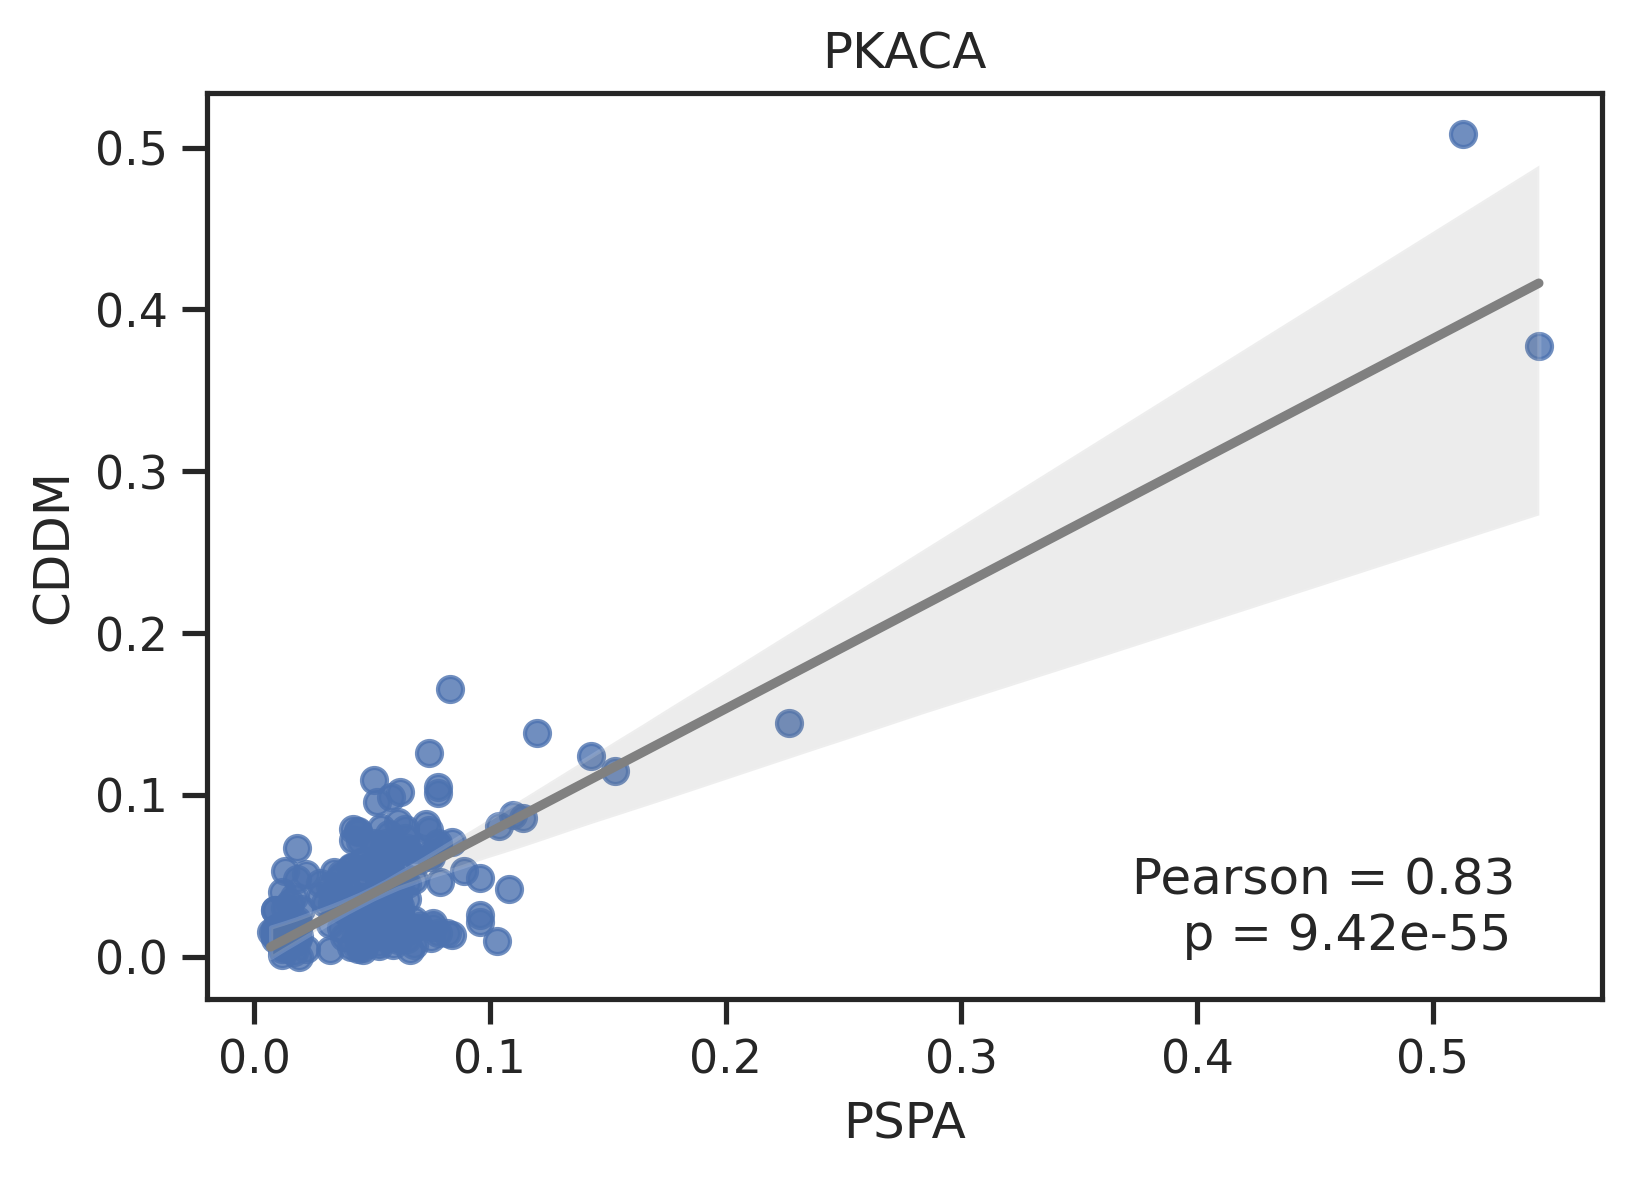

  0%|          | 0/202 [00:01<?, ?it/s]


In [ ]:
for k in tqdm(overlap_cnt.index,total=len(overlap_cnt)):
    df_k = df.query(f'kinase_paper=="{k}"')
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    paper,full = get_freq(df_k)
    raw_k = get_one_kinase(norm,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    plot_heatmap(paper,f'{k} from CDDM (n={overlap_cnt[k]})')
    # plt.savefig(f'corr/KS/{k}.png',bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

    plot_heatmap(raw_k,f'{k} from PSPA')
    # plt.savefig(f'corr/PSPA/{k}.png',bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

    plot_corr(y = paper.unstack().values, #dataset driven
              x = raw_k.unstack().values, # PSPA
              ylabel='CDDM',
              xlabel='PSPA')
    plt.title(k)
    # plt.savefig(f'corr/pear/{k}.png',bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()
    
    break

Combine the figures: correlation on top, and two heatmaps on the bottom

In [ ]:
def combine_images_custom_layout(image_paths, output_path):
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    # Calculate total width and height for the new image
    total_width = max(images[0].width, images[1].width + images[2].width)
    total_height = images[0].height + max(images[1].height, images[2].height)
    
    # Create a new image with calculated dimensions
    combined_image = Image.new('RGBA', (total_width, total_height))
    
    # Paste the first image at the top-center
    x_offset = (total_width - images[0].width) // 2
    combined_image.paste(images[0], (x_offset, 0), images[0])
    
    # Paste the second image at the bottom-left
    combined_image.paste(images[1], (0, images[0].height), images[1])
    
    # Paste the third image at the bottom-right
    combined_image.paste(images[2], (images[1].width, images[0].height), images[2])
    
    # Save the result
    combined_image.save(output_path)

Uncheck below to save combined figures

In [ ]:
# folders = ["corr/pear",'corr/KS','corr/PSPA']

# for k in tqdm(overlap_cnt.index,total=len(overlap_cnt)):
#     filename = f"{k}.png"
#     image_paths = [os.path.join(folder, filename) for folder in folders]
#     output_path = f"corr/combine/{k}.png"
#     combine_images_custom_layout(image_paths, output_path)
#     # break

## Plot comparison

***Correlation with raw PSPA***

In [ ]:
data = []
for k in overlap_cnt.index:
    df_k = df.query(f'kinase_paper=="{k}"')
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    cnt = df_k.shape[0]
    
    paper,full = get_freq(df_k)
    raw_k = get_one_kinase(raw,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    full_corr,_ = pearsonr(raw_k.unstack().values,paper.unstack().values)
    
    data.append([k,full_corr,cnt])
    

In [ ]:
corr_raw = pd.DataFrame(data,columns= ['kinase','corr_with_raw','count_unique'])

***Correlation with normalized PSPA***

In [ ]:
data = []
for k in overlap_cnt.index:
    df_k = df.query(f'kinase_paper=="{k}"')
    df_k = df_k.drop_duplicates(subset='SUB').reset_index()
    
    cnt = df_k.shape[0]
    
    paper,full = get_freq(df_k)
    norm_k = get_one_kinase(norm,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    full_corr,_ = pearsonr(norm_k.unstack().values,paper.unstack().values)
    
    data.append([k,full_corr])
    

In [ ]:
corr_norm = pd.DataFrame(data,columns= ['kinase','corr_with_norm',
                                ])

***Merge with specificity***

In [ ]:
corr = corr_raw.merge(corr_norm)

In [ ]:
m = pd.read_csv('raw/specificity_pspa.csv')

In [ ]:
corr= corr.merge(m).rename(columns={'max':'specificity'})

In [ ]:
corr

,kinase,corr_with_raw,count_unique,corr_with_norm,specificity
0,PKACA,0.841437,1547,0.833627,0.476953
1,ERK2,0.755683,1241,0.830667,0.510499
2,CDK1,0.867922,1197,0.880447,0.569784
3,IKKB,0.151149,1133,0.278715,0.157279
4,ERK1,0.832991,1048,0.880669,0.567533
...,...,...,...,...,...
197,HIPK3,0.650688,97,0.709181,0.399684
198,CDK8,0.391844,89,0.479039,0.542519
199,BUB1,0.222991,86,0.253001,0.240232
200,MEKK3,-0.100448,85,0.008627,0.127274


In [ ]:
corr.query('kinase == "CK1A"')

,kinase,corr_with_raw,count_unique,corr_with_norm,specificity
116,CK1A,0.221291,293,0.227877,0.79104


***Pearson vs. Specificity***

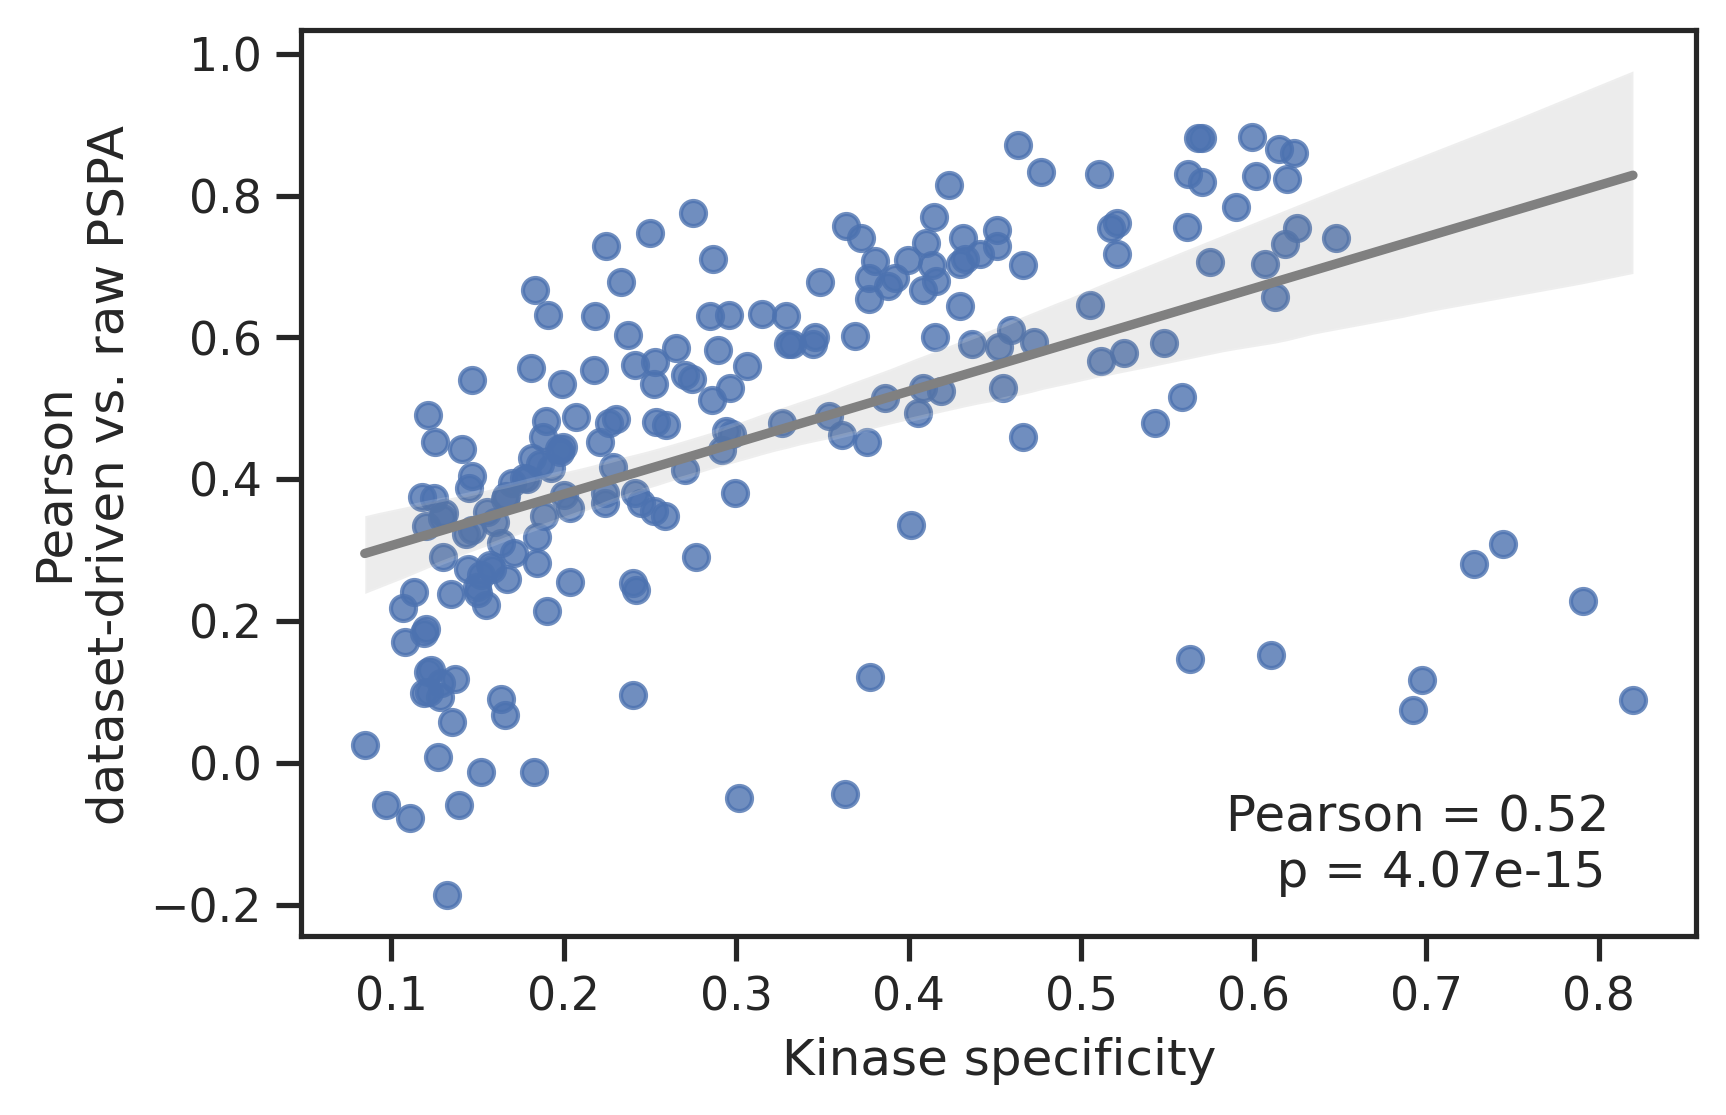

In [ ]:
plot_corr(x=corr.specificity.values,
          y=corr.corr_with_norm.values)
plt.ylabel('Pearson\n dataset-driven vs. raw PSPA')
plt.xlabel('Kinase specificity');

In [ ]:
info = Data.get_kinase_info().query('pseudo=="0"')

corr2 = corr.merge(info)

color = load_pickle('raw/kinase_color.pkl')

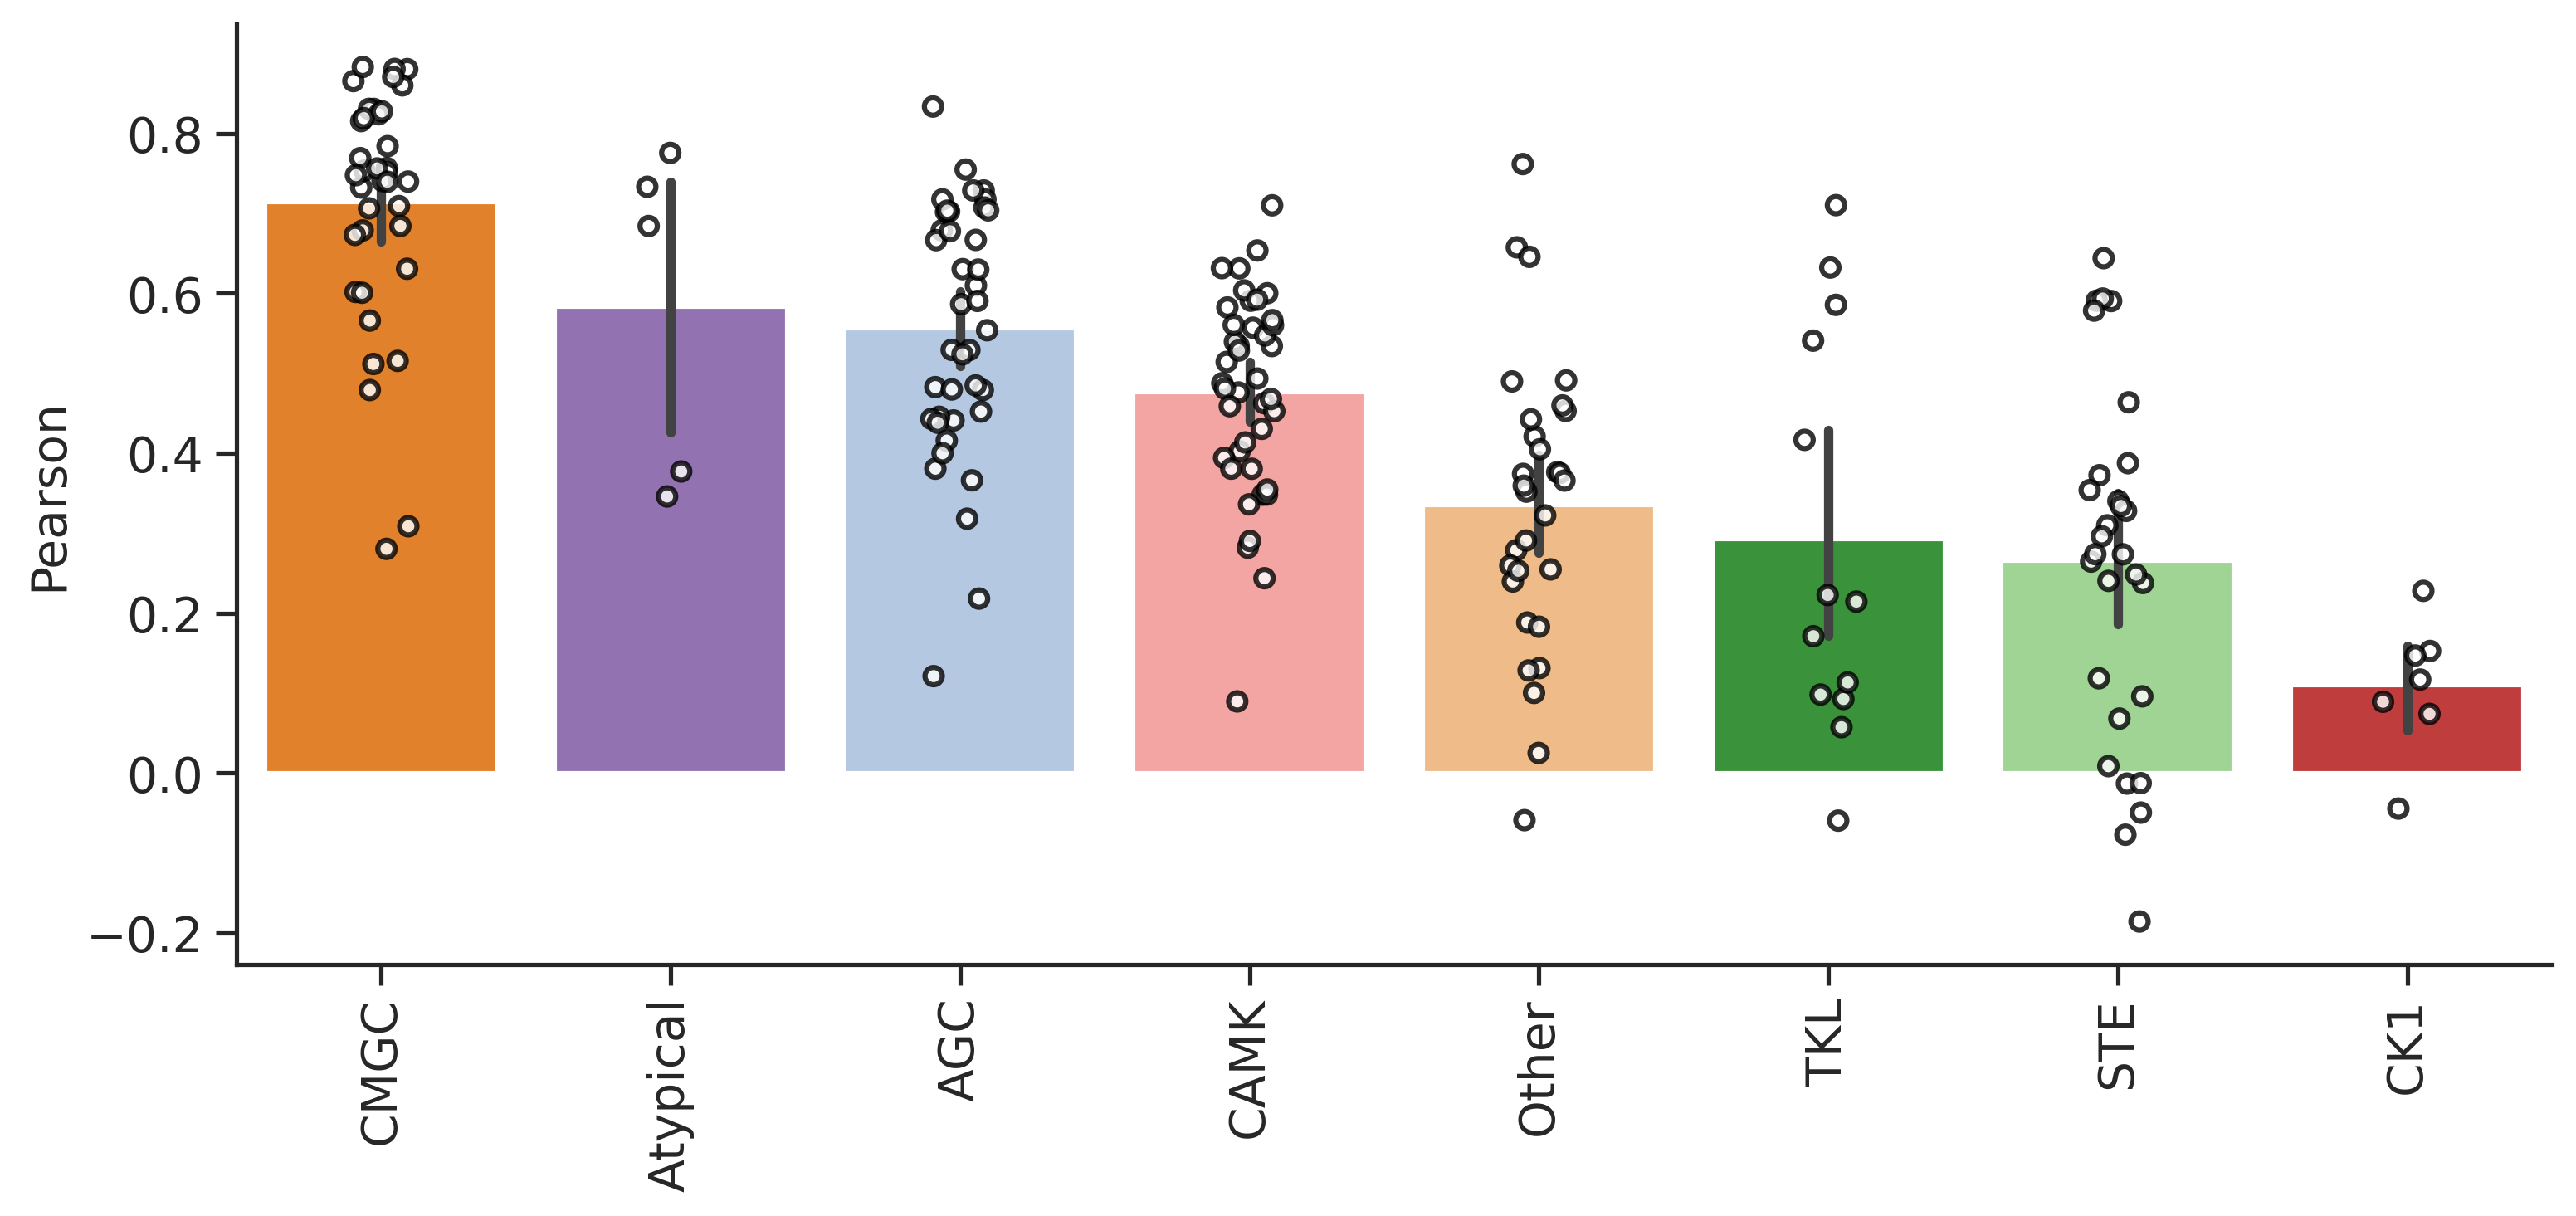

In [ ]:
plot_bar(corr2,'corr_with_norm','group',palette=color)
plt.ylabel('Pearson');

Text(0.5, 1.0, 'Distribution of Pearson score')

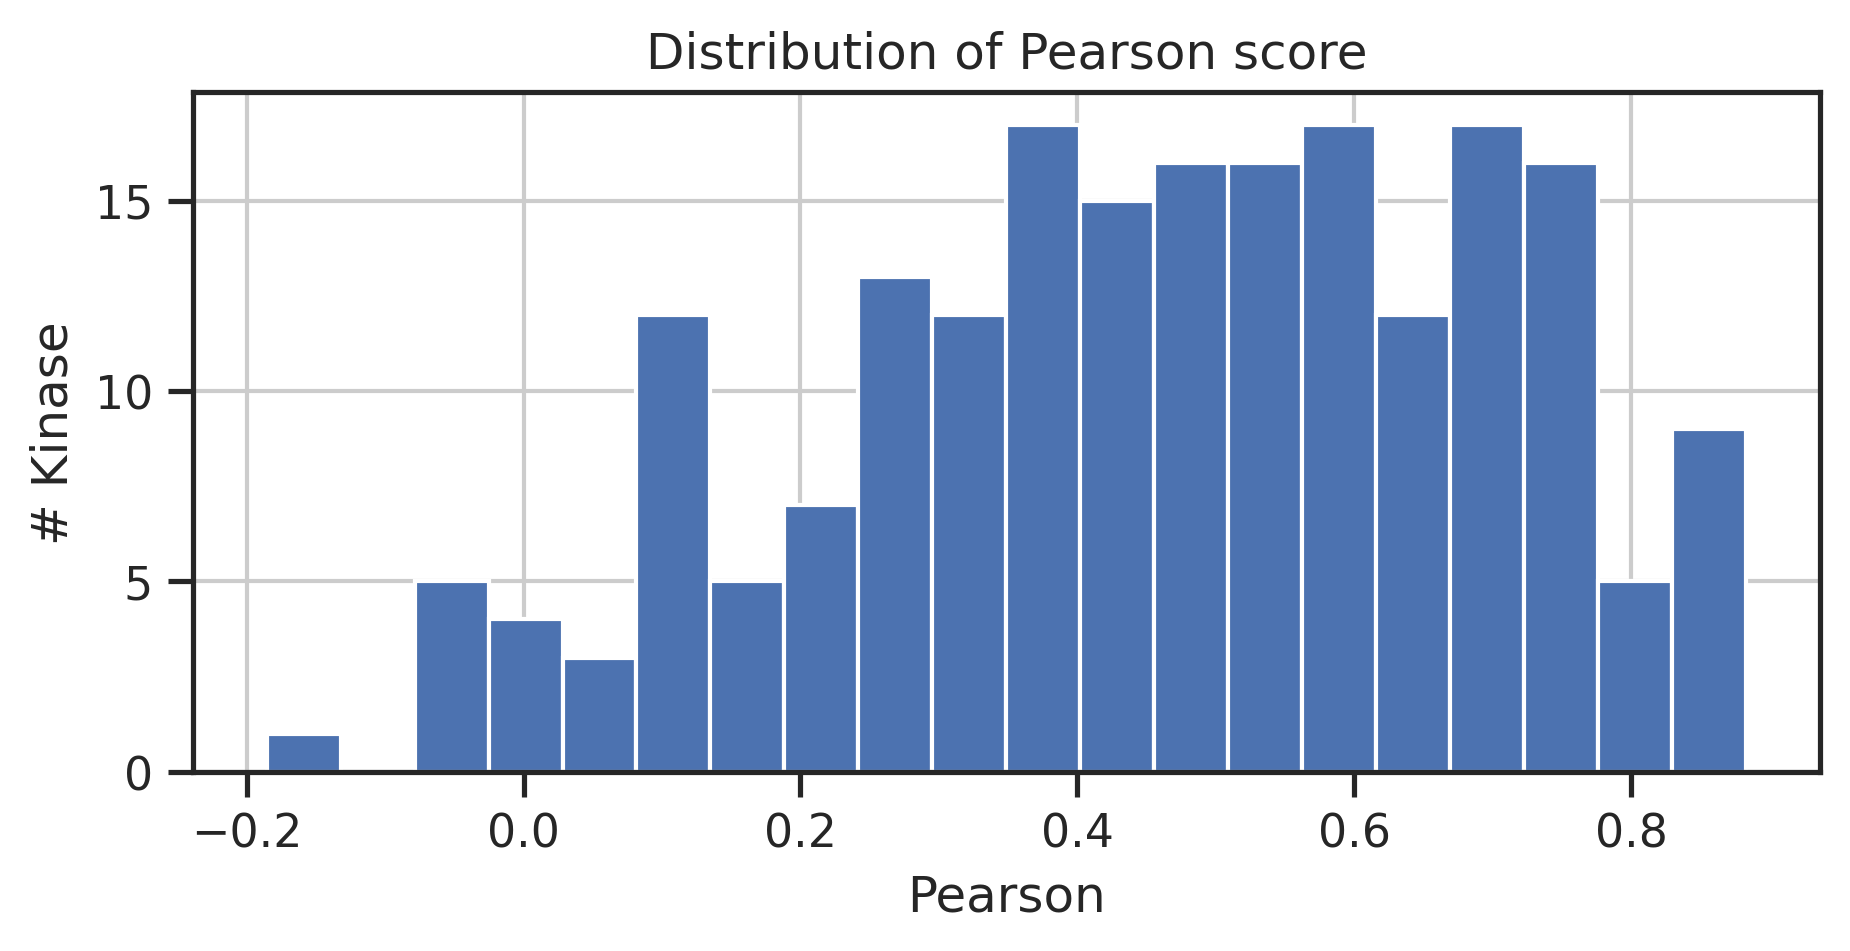

In [ ]:
plt.figure(figsize=(7,3))
corr.corr_with_norm.hist(bins=20)
plt.xlabel('Pearson')
plt.ylabel('# Kinase')
plt.title('Distribution of Pearson score')

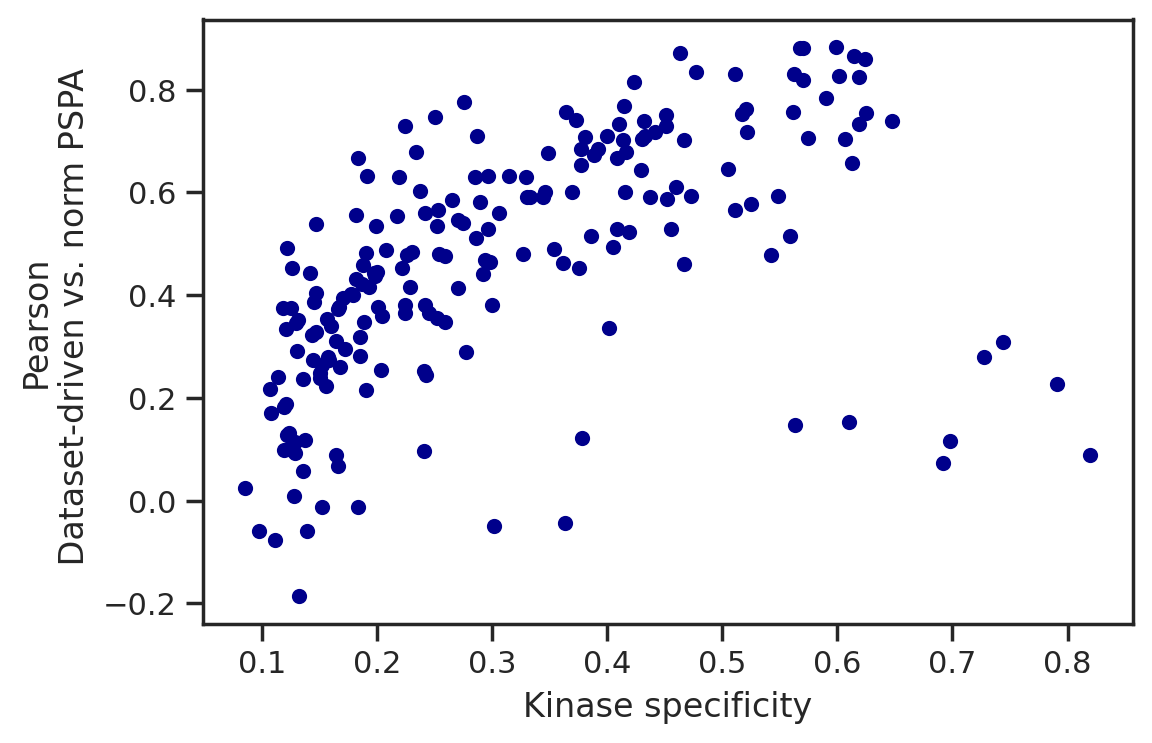

In [ ]:
corr.plot.scatter(y='corr_with_norm',x='specificity',c='darkblue')
plt.ylabel('Pearson\n Dataset-driven vs. norm PSPA')
plt.xlabel('Kinase specificity');
# plt.title('Dataset-driven vs. raw PSPA')

***Examples of outliers***

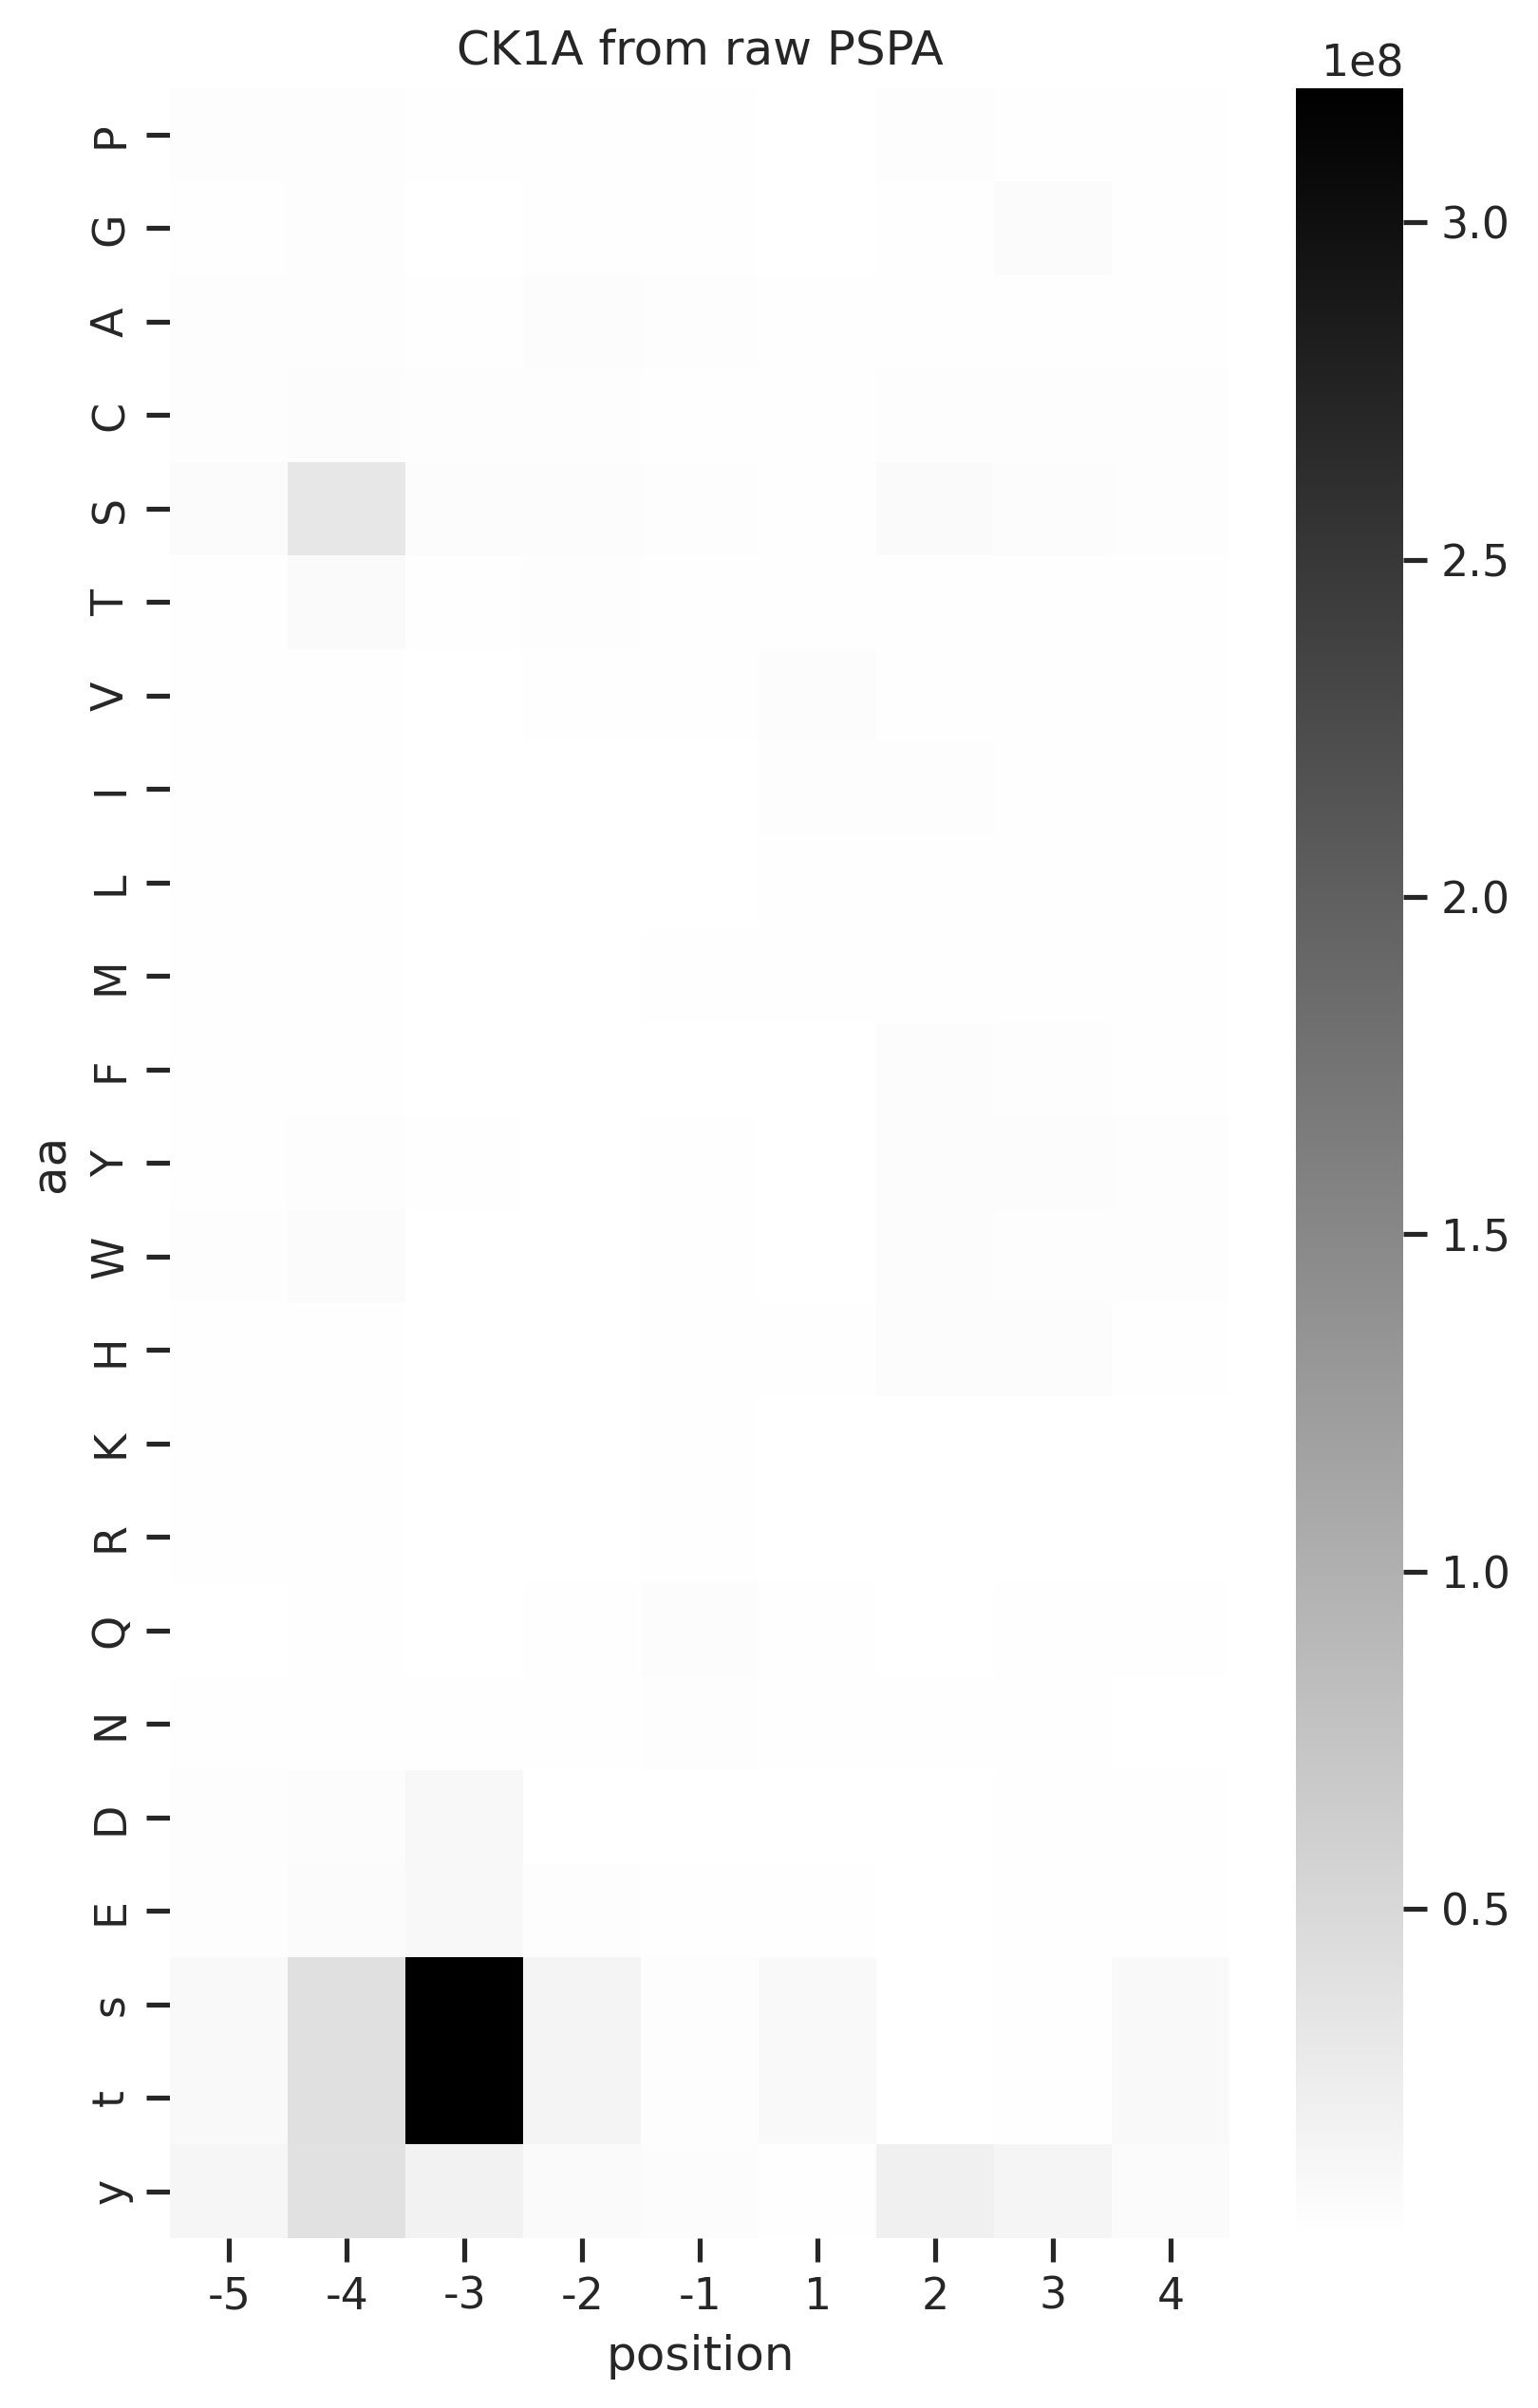

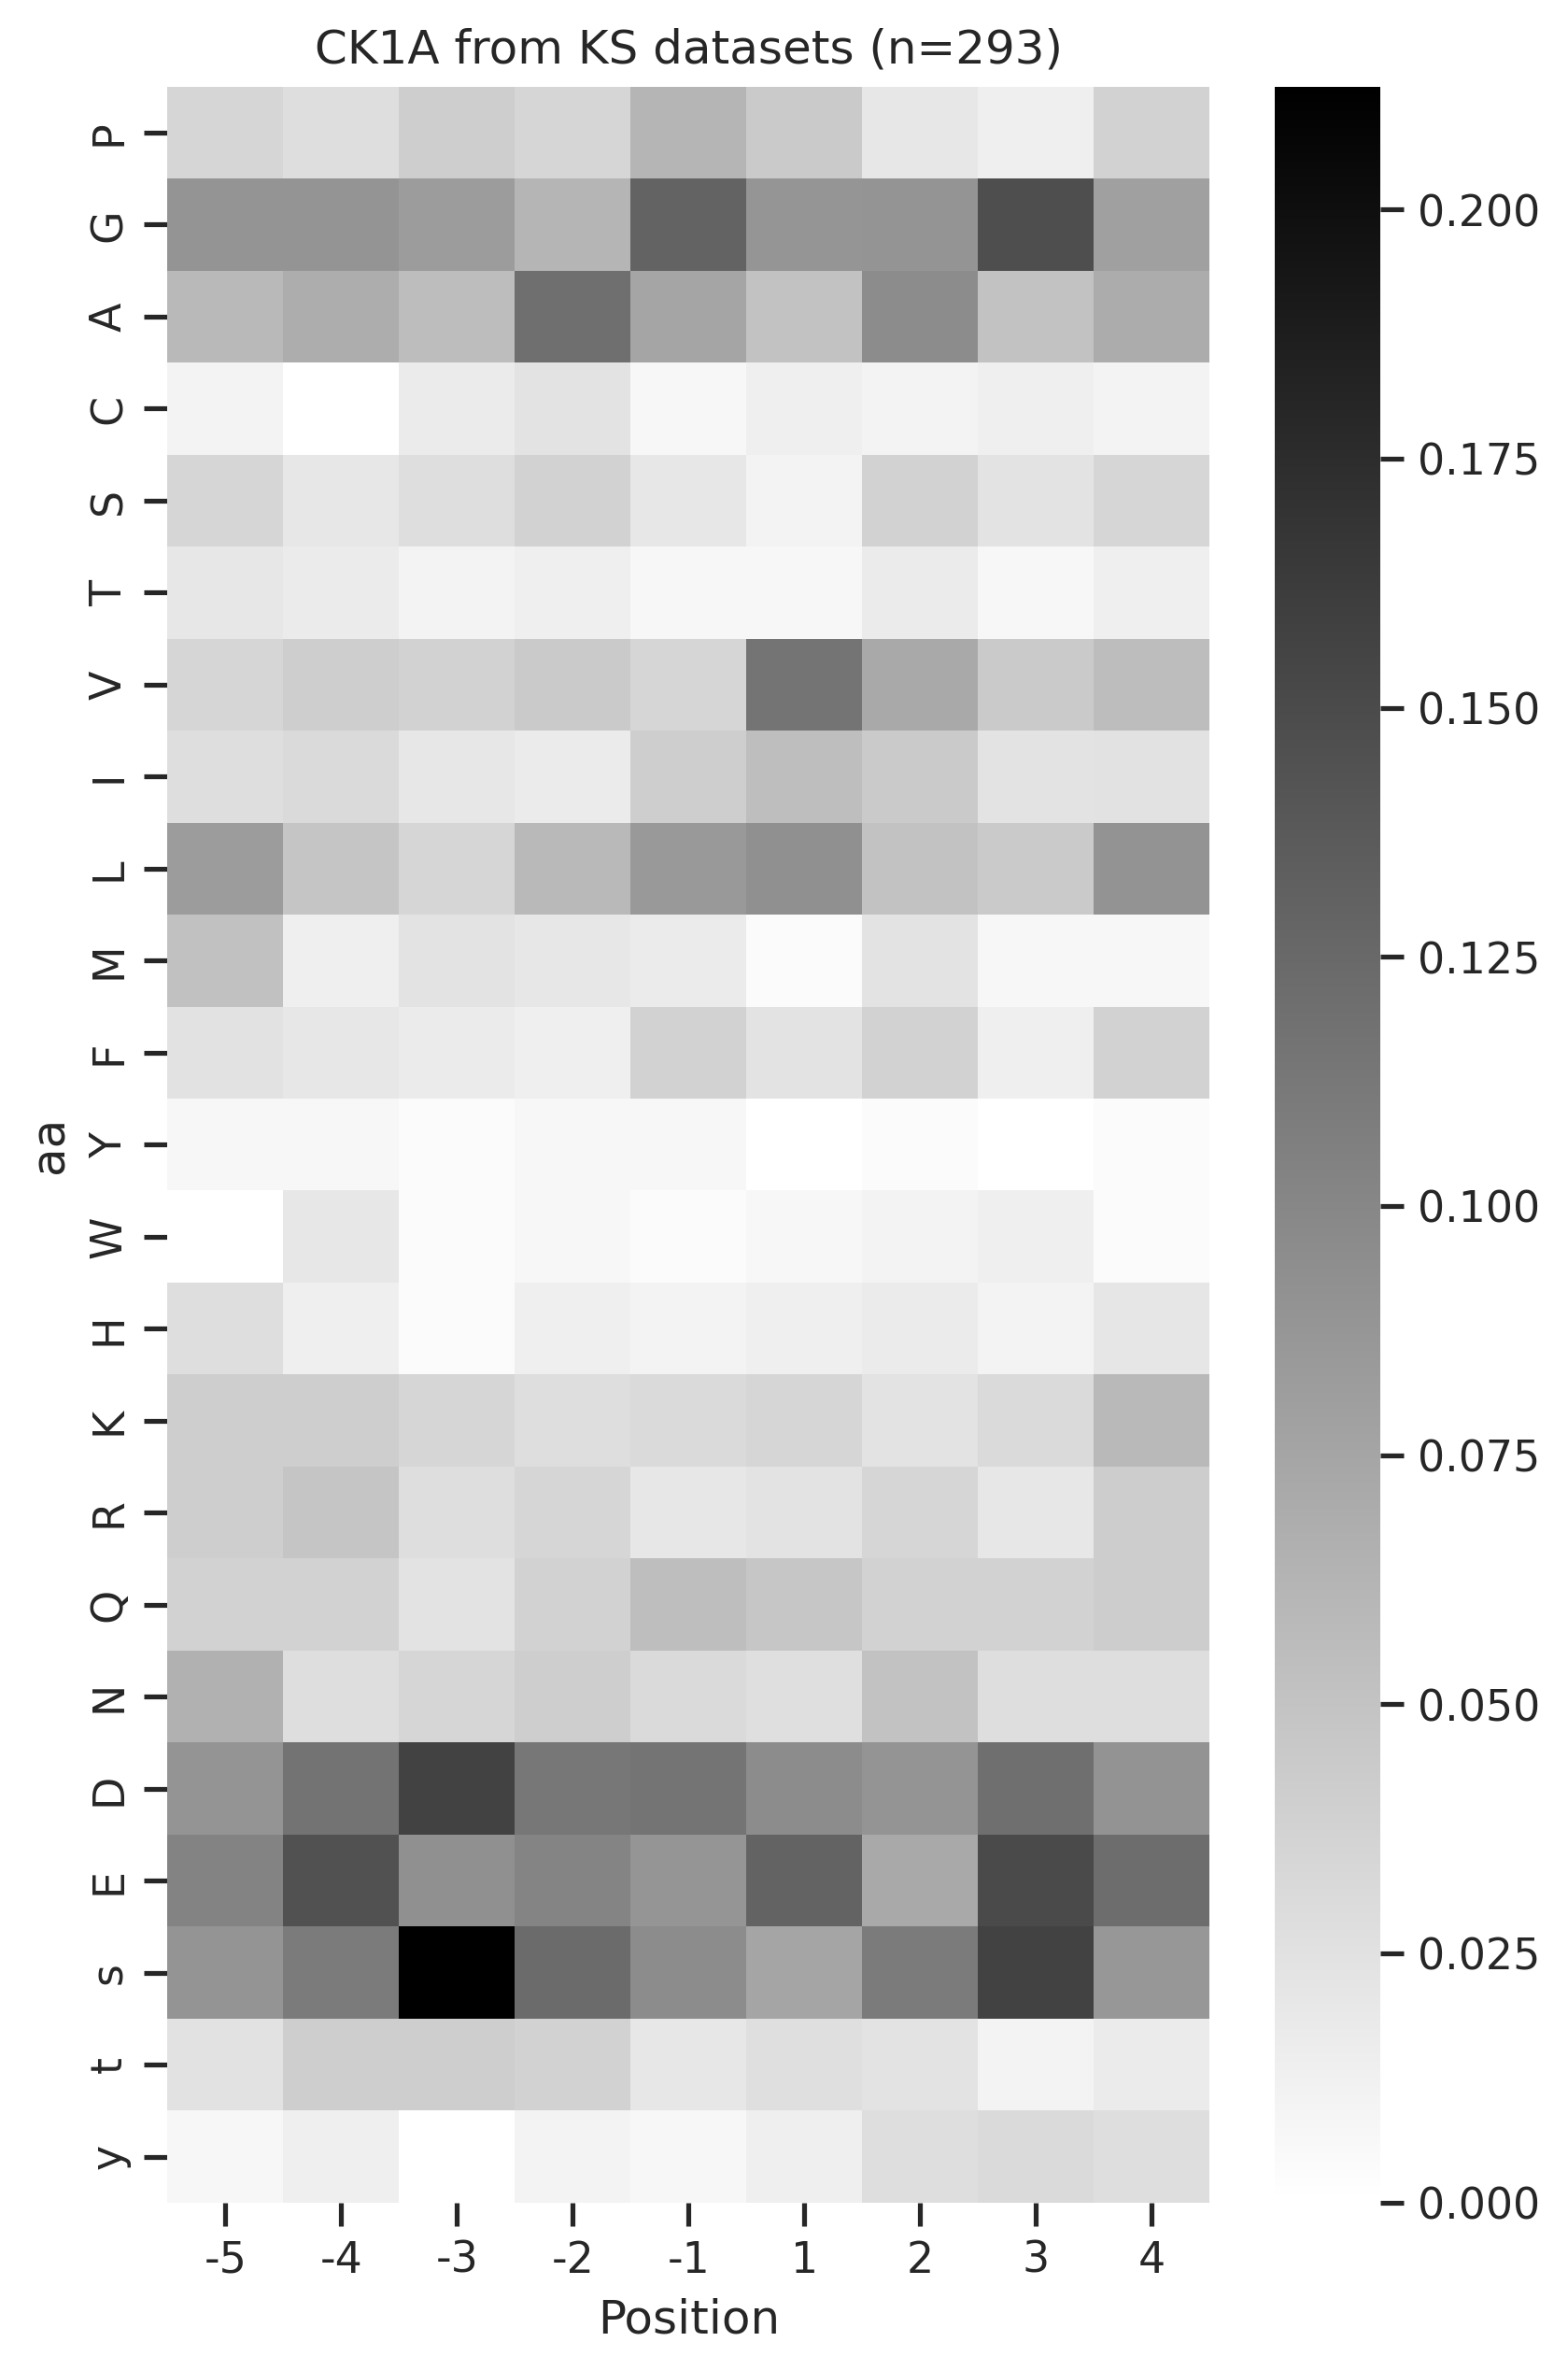

In [ ]:
# Examples of data
k = 'CK1A'
df_k=df.query(f'kinase_paper == "{k}"')
df_k=df_k.drop_duplicates(subset='SUB')

paper, full = get_freq(df_k)

raw_k = get_one_kinase(raw,k,drop_s=False).T
raw_k = raw_k.reindex(index=aa_order_paper)

plot_heatmap(raw_k,f'{k} from raw PSPA')
plot_heatmap(paper,f'{k} from KS datasets (n={len(df_k)})')

To check all of the outliers, uncheck below

In [ ]:
# # Examples of data
# for k in corr.query('corr_with_norm<0.4 & specificity>0.55').kinase:
    
#     df_k=df.query(f'kinase_paper == "{k}"')
#     df_k=df_k.drop_duplicates(subset='SUB')

#     paper, full = get_freq(df_k)

#     raw_k = get_one_kinase(raw,k,drop_s=False).T
#     raw_k = raw_k.reindex(index=aa_order_paper)
    
#     plot_heatmap(raw_k,f'{k} from raw PSPA')
#     plot_heatmap(paper,f'{k} from KS datasets (n={len(df_k)})')

### Pearson with raw vs. Pearson with norm

In [ ]:
melt = pd.melt(corr[['corr_with_raw','corr_with_norm']])

In [ ]:
melt['variable'] = melt.variable.replace({'corr_with_raw':'raw','corr_with_norm':'normalized'})

In [ ]:
def plot_box(data,x,y,dots=True):
    if dots:
        sns.stripplot(data=data,x=x,y=y)
    sns.boxplot(data=data, x=x, y=y, palette='pastel')

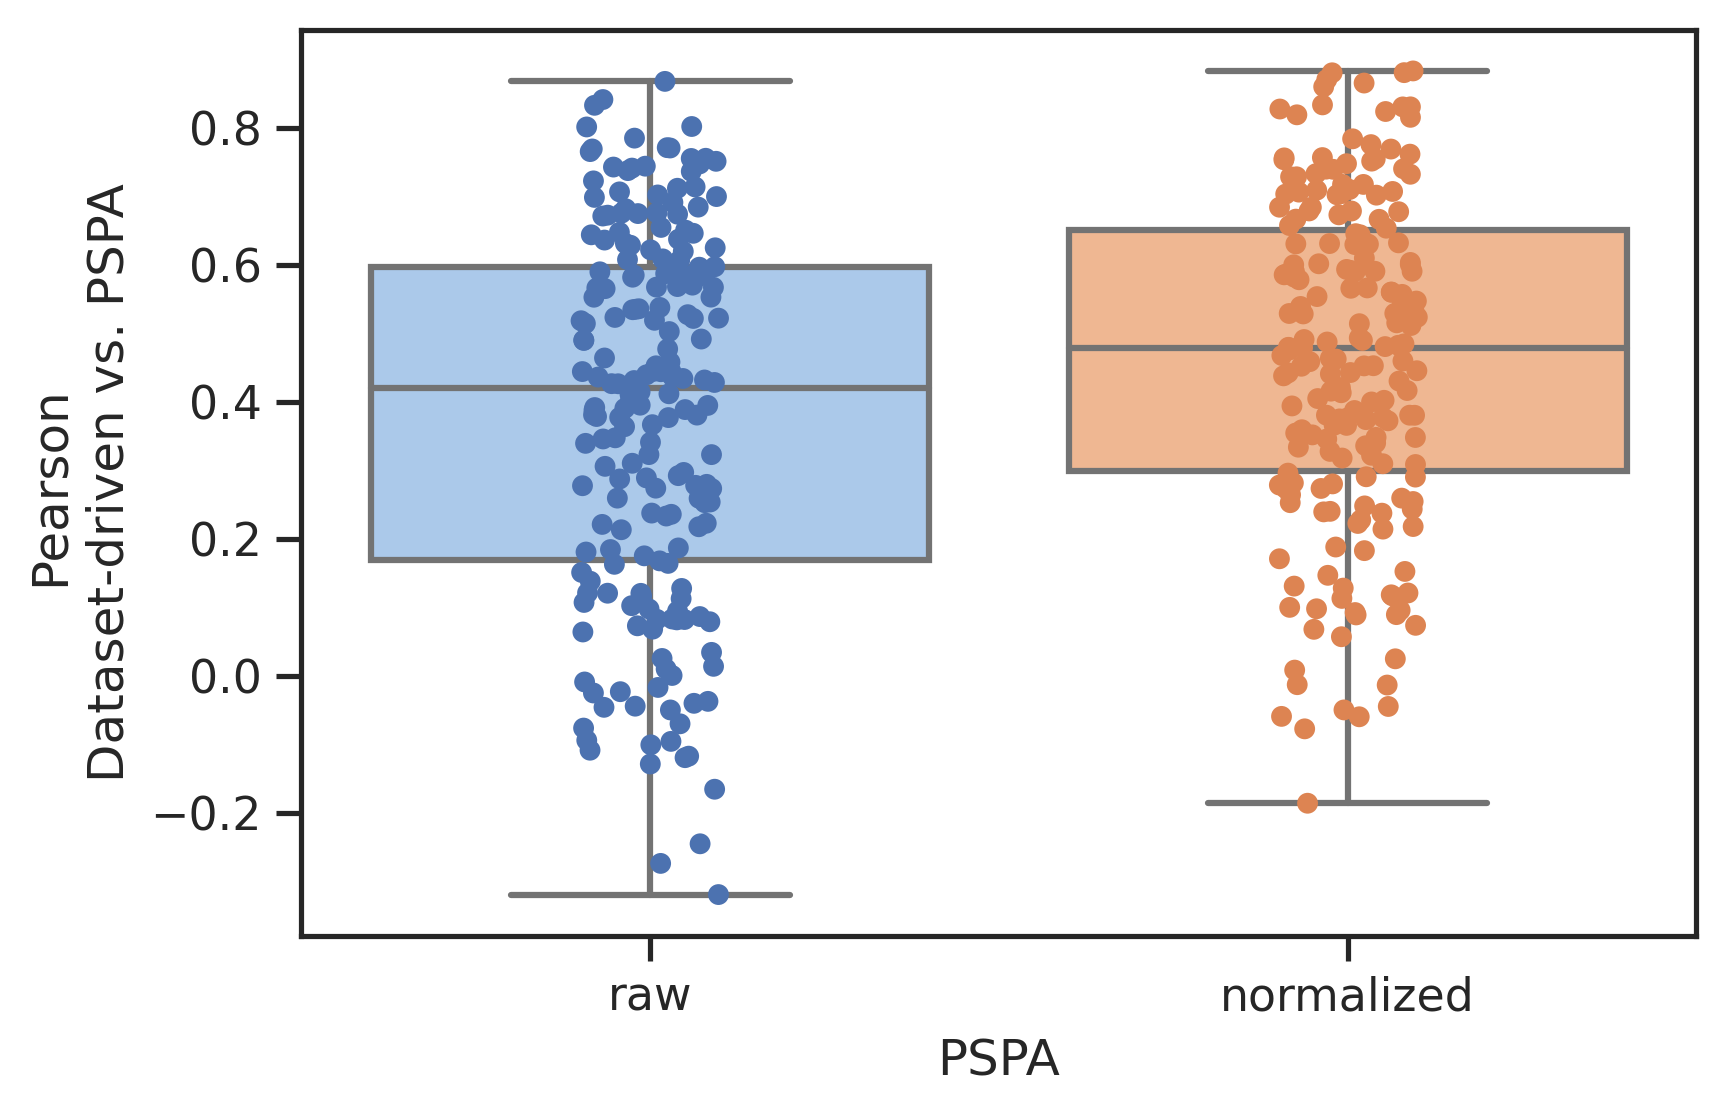

In [ ]:
plot_box(melt,'variable','value')
plt.ylabel('Pearson \nDataset-driven vs. PSPA')
plt.xlabel('PSPA');

### Check if changed pearson is correlated with specificity

In [ ]:
corr['change_corr'] = corr['corr_with_norm'] - corr['corr_with_raw']

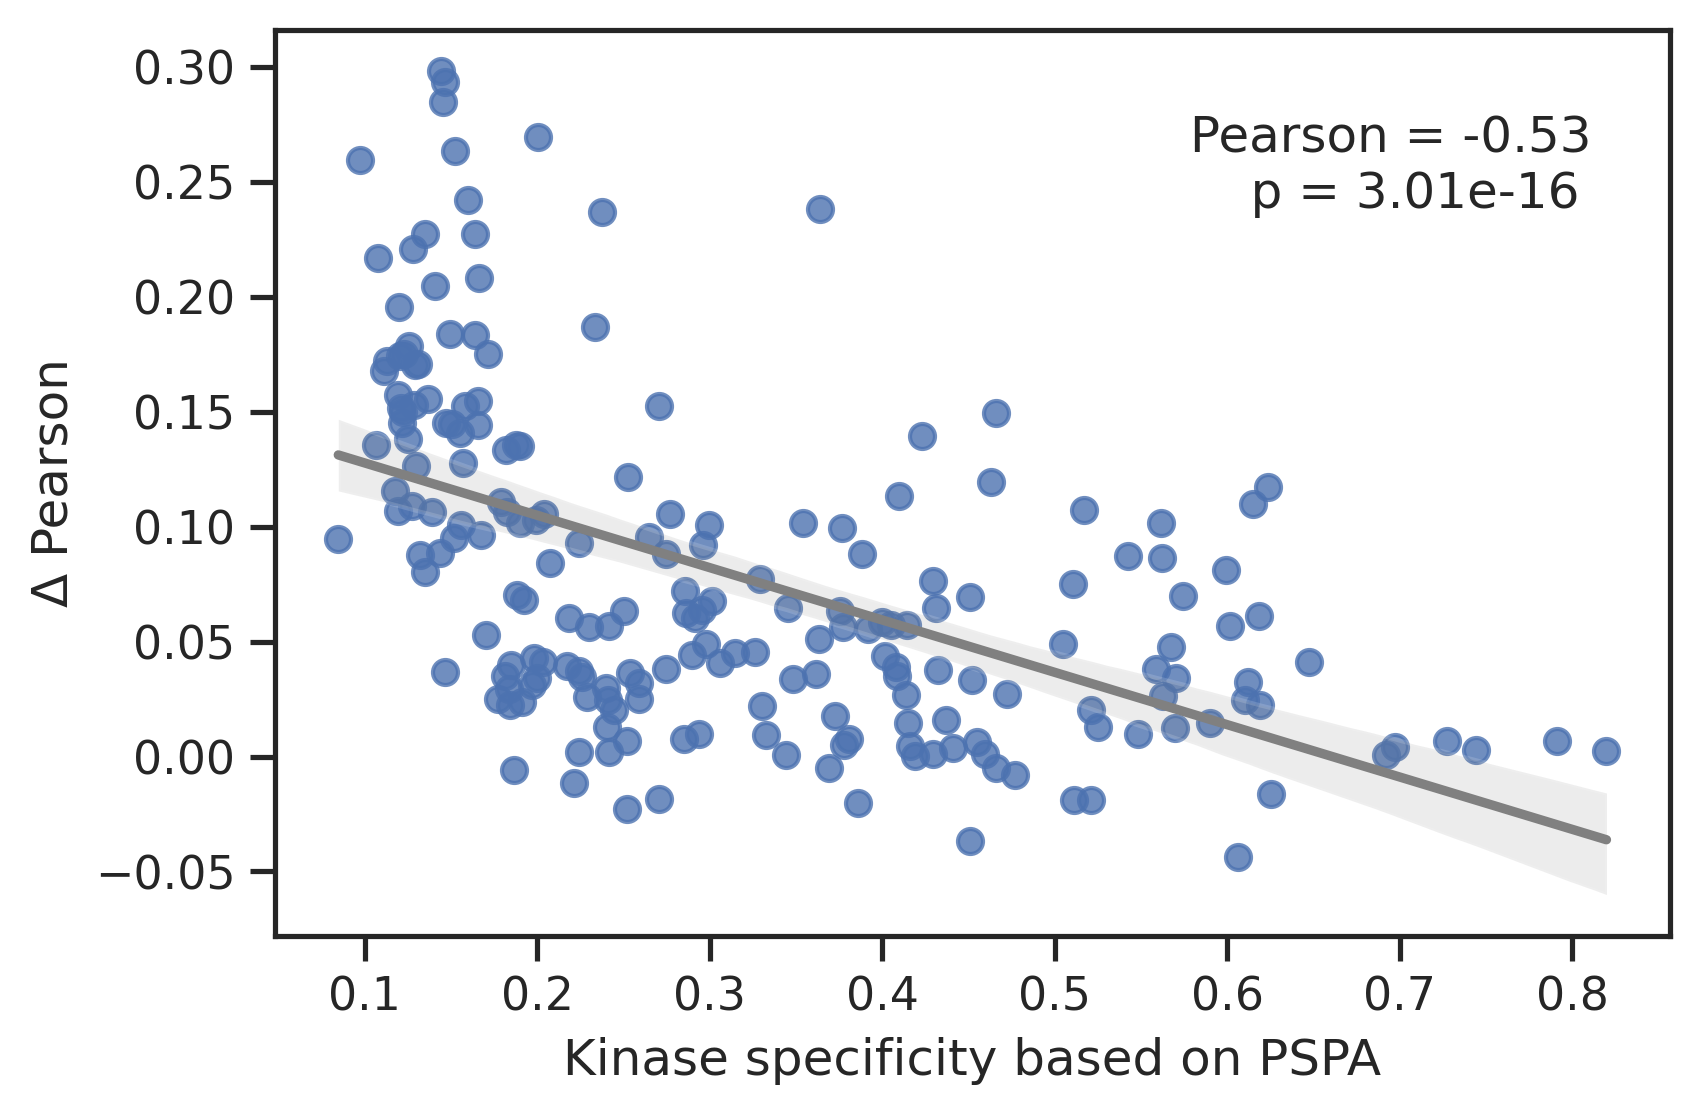

In [ ]:
plot_corr(y=corr.change_corr,x=corr.specificity,text_location=[0.8,0.85])
plt.xlabel('Kinase specificity based on PSPA')
plt.ylabel('Δ Pearson');

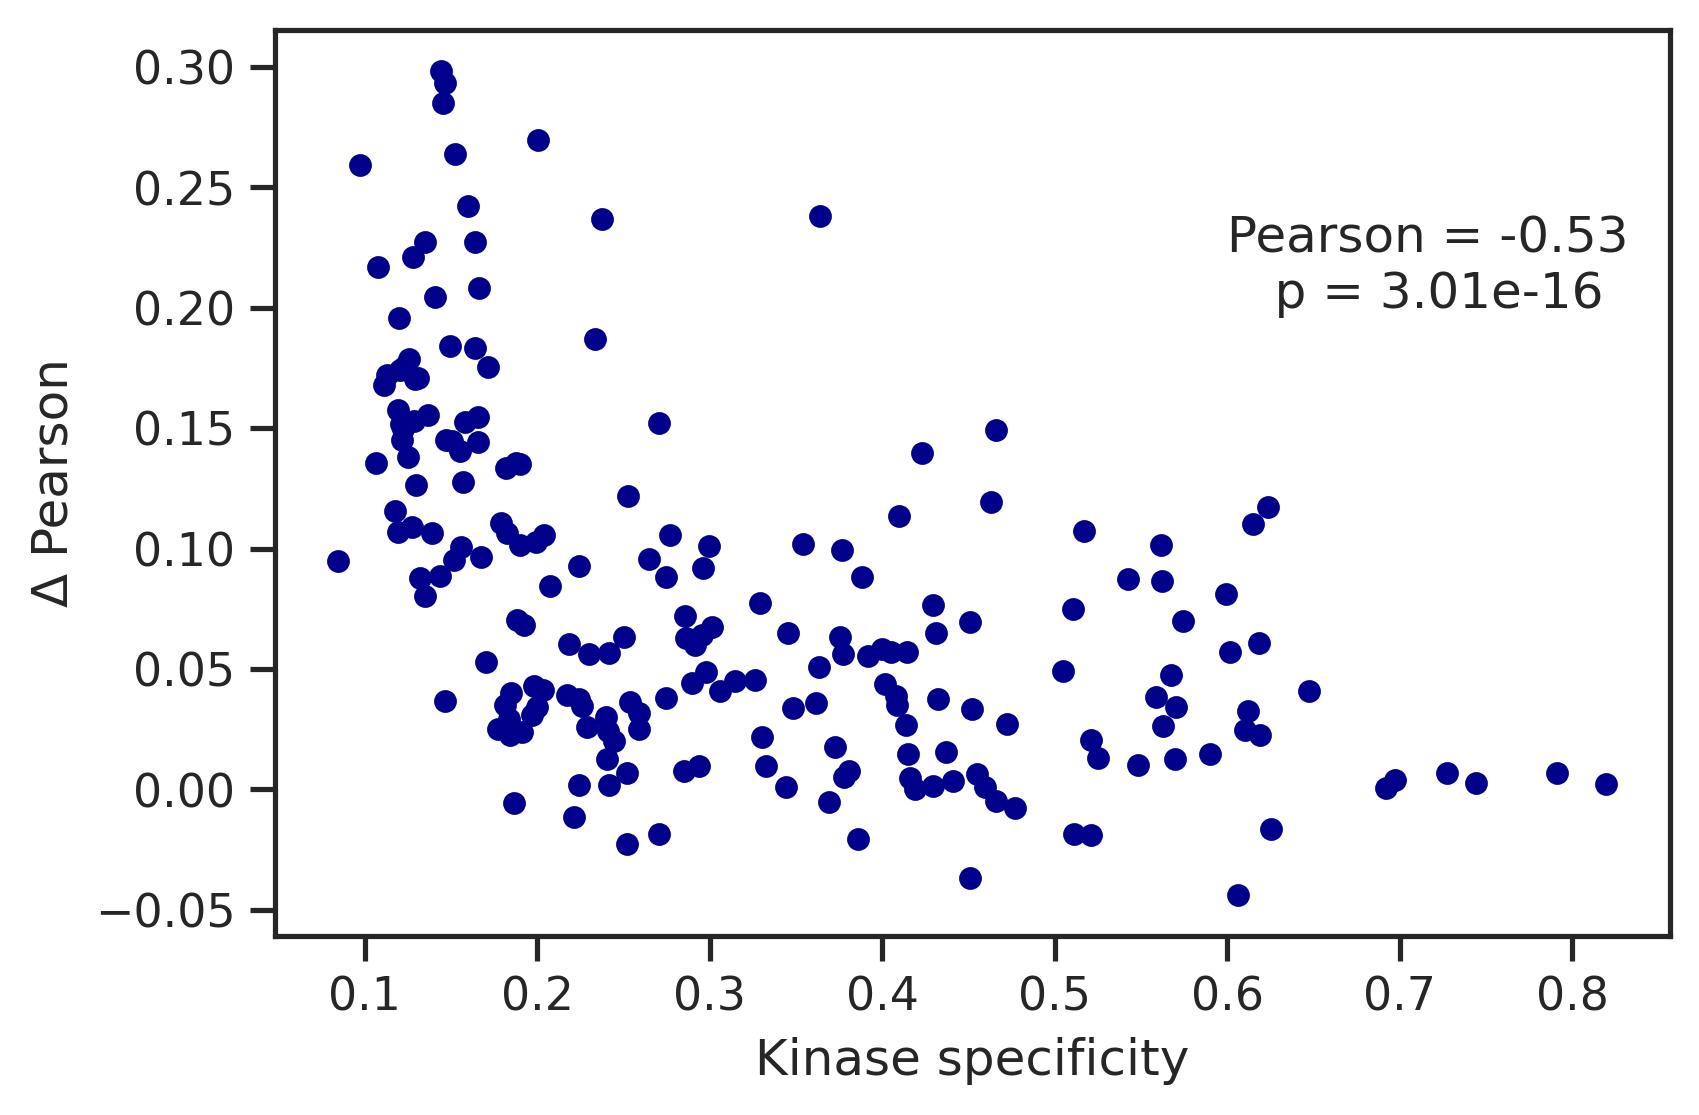

In [ ]:
corr.plot.scatter(y='change_corr',x='specificity',c='darkblue')
pear,pvalue = pearsonr(corr.change_corr,corr.specificity)
plt.text(s=f'Pearson = {round(pear,2)}\n   p = {"{:.2e}".format(pvalue)}',x=0.6,y=0.2)
plt.ylabel('Δ Pearson')
plt.xlabel('Kinase specificity');

In [ ]:
# corr.to_csv('PSSM_vs_dataset_summary.csv',index=False)

### Find out the factor that cause the biggest change in correlation

Plot the kinase with biggest change in pearson after normalization

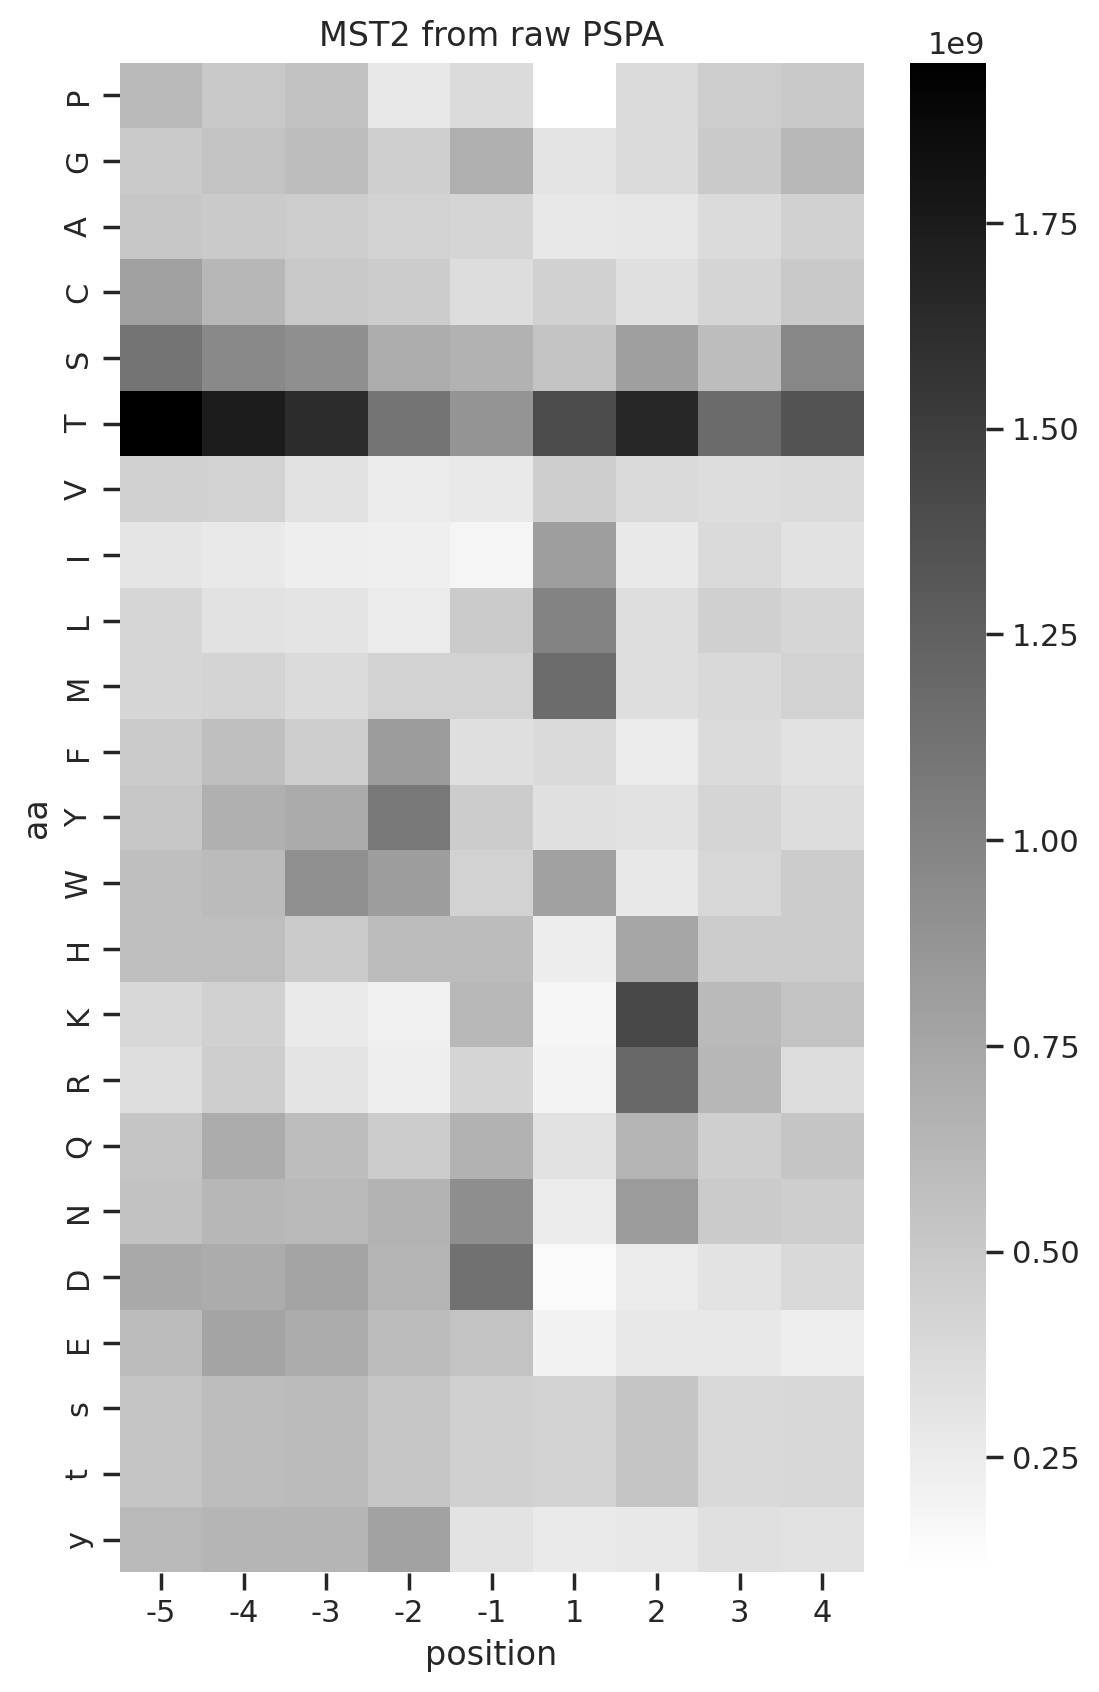

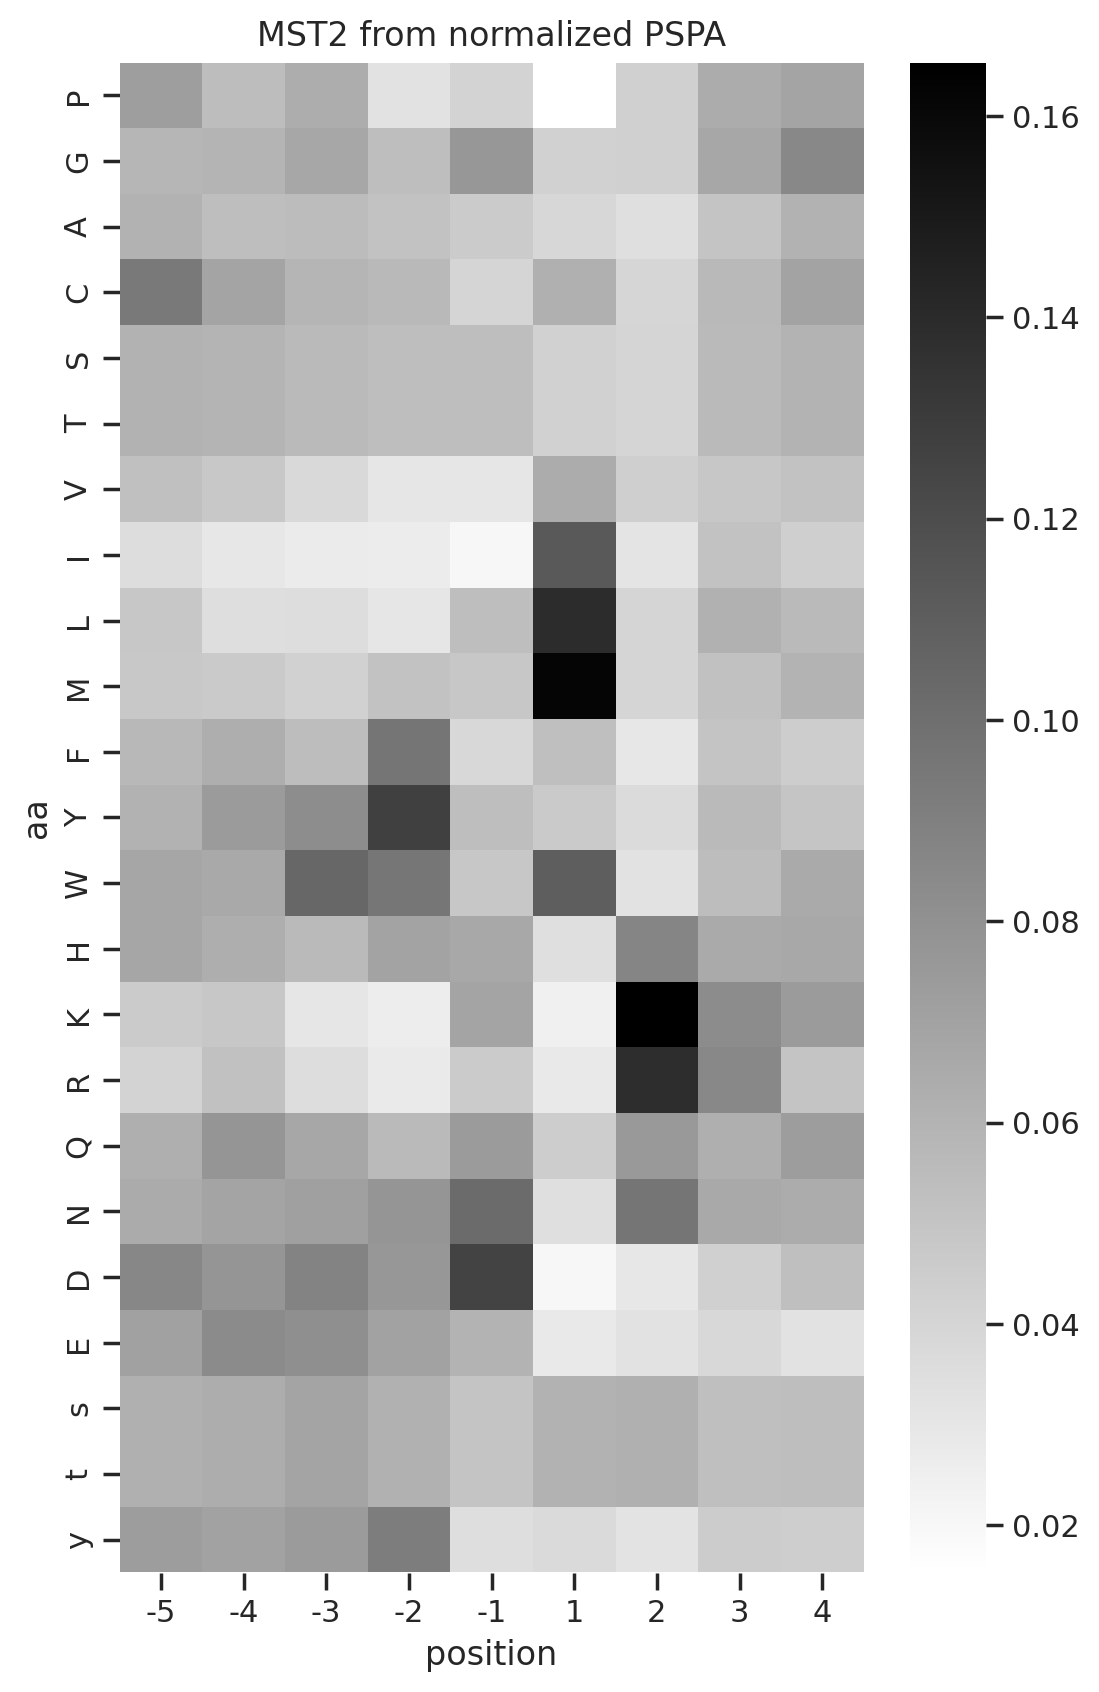

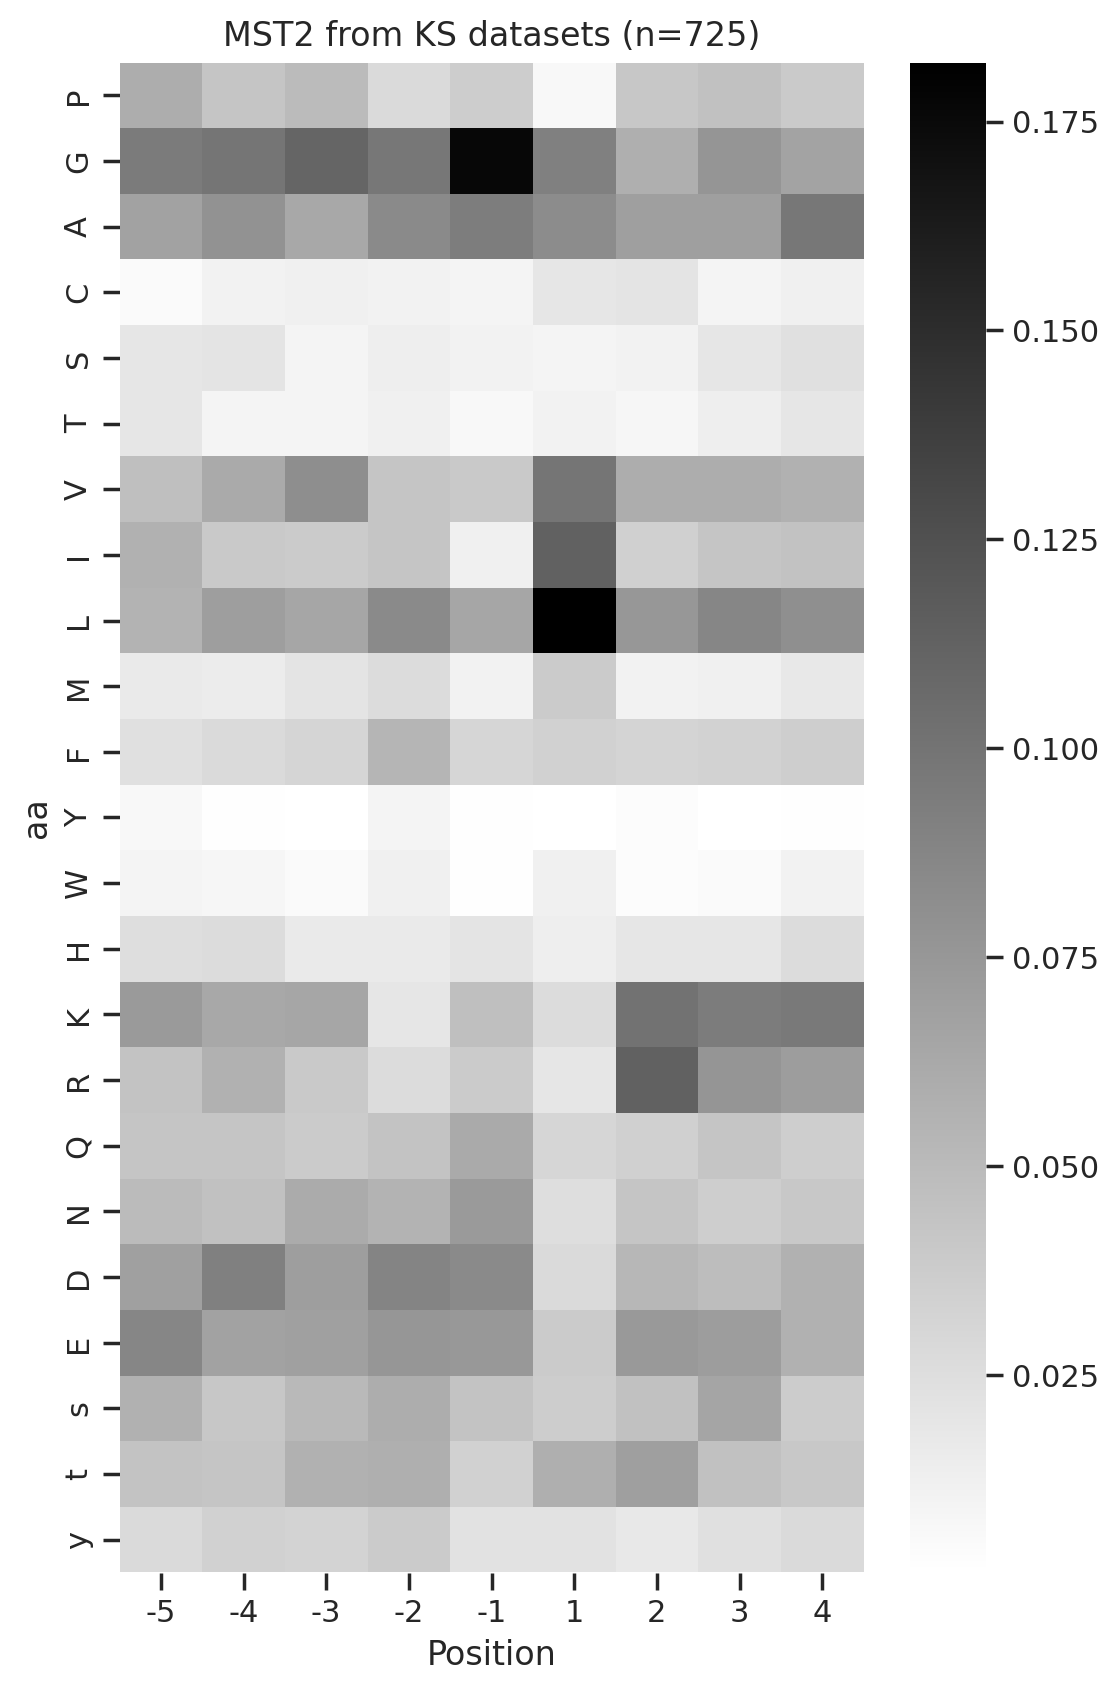

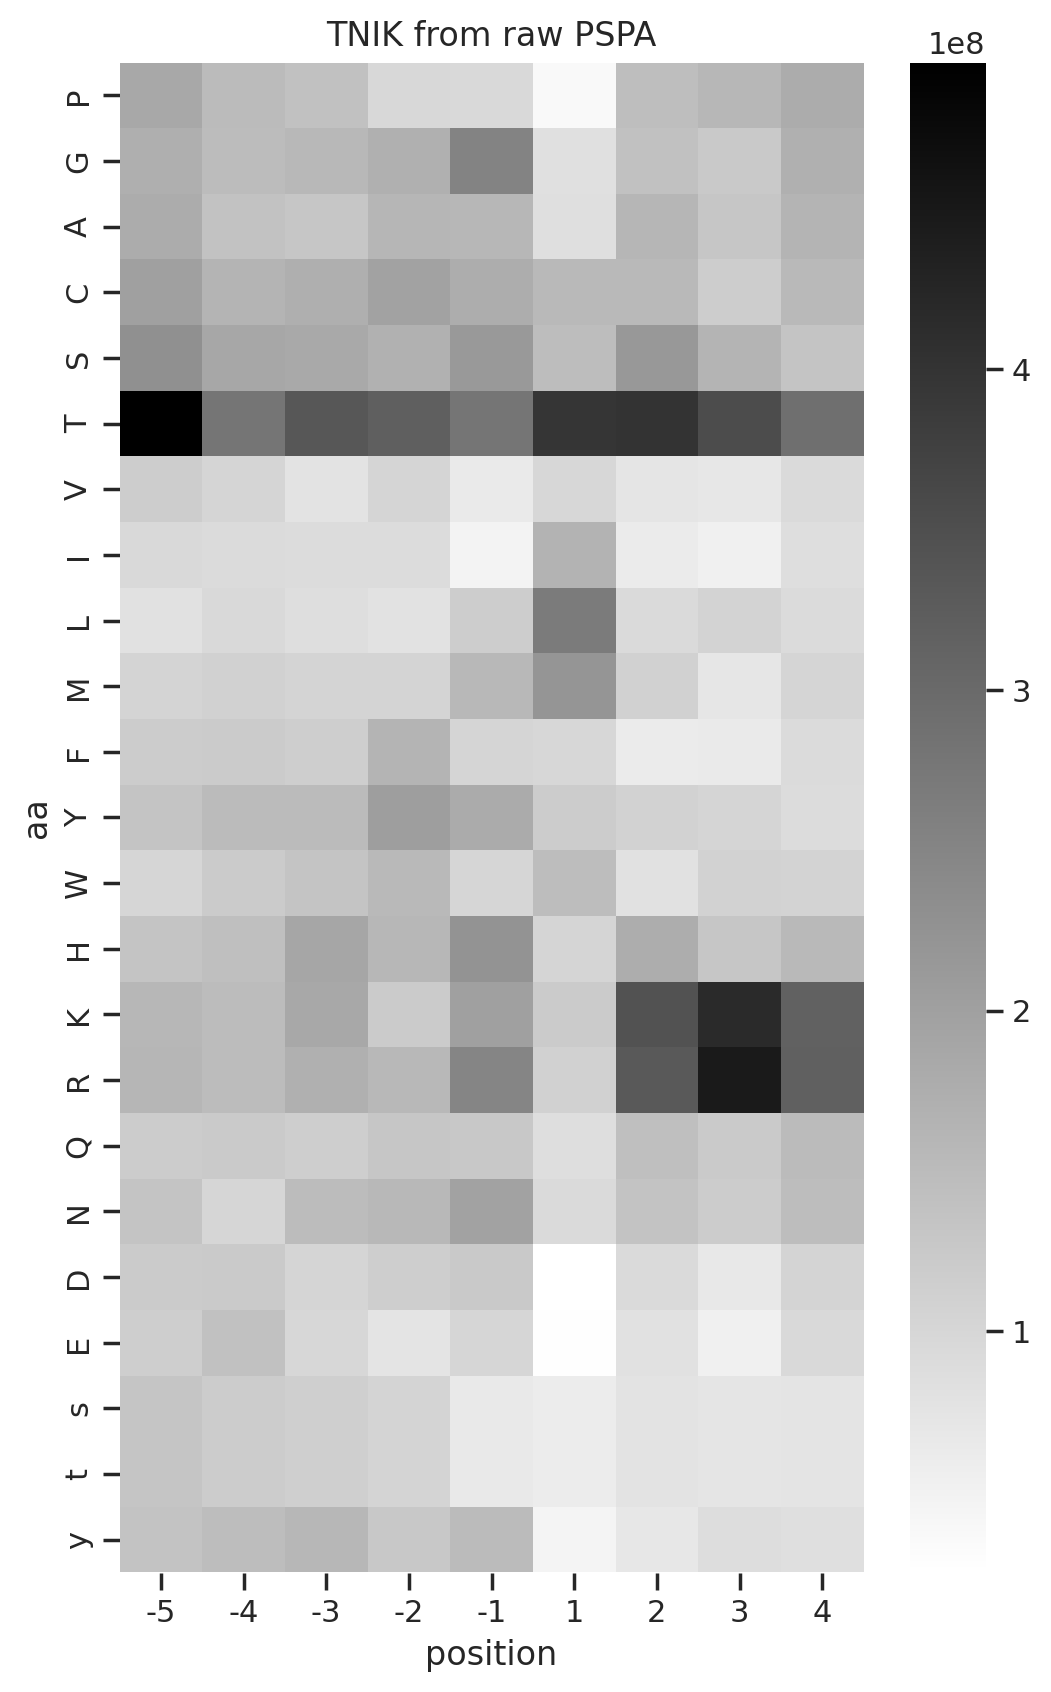

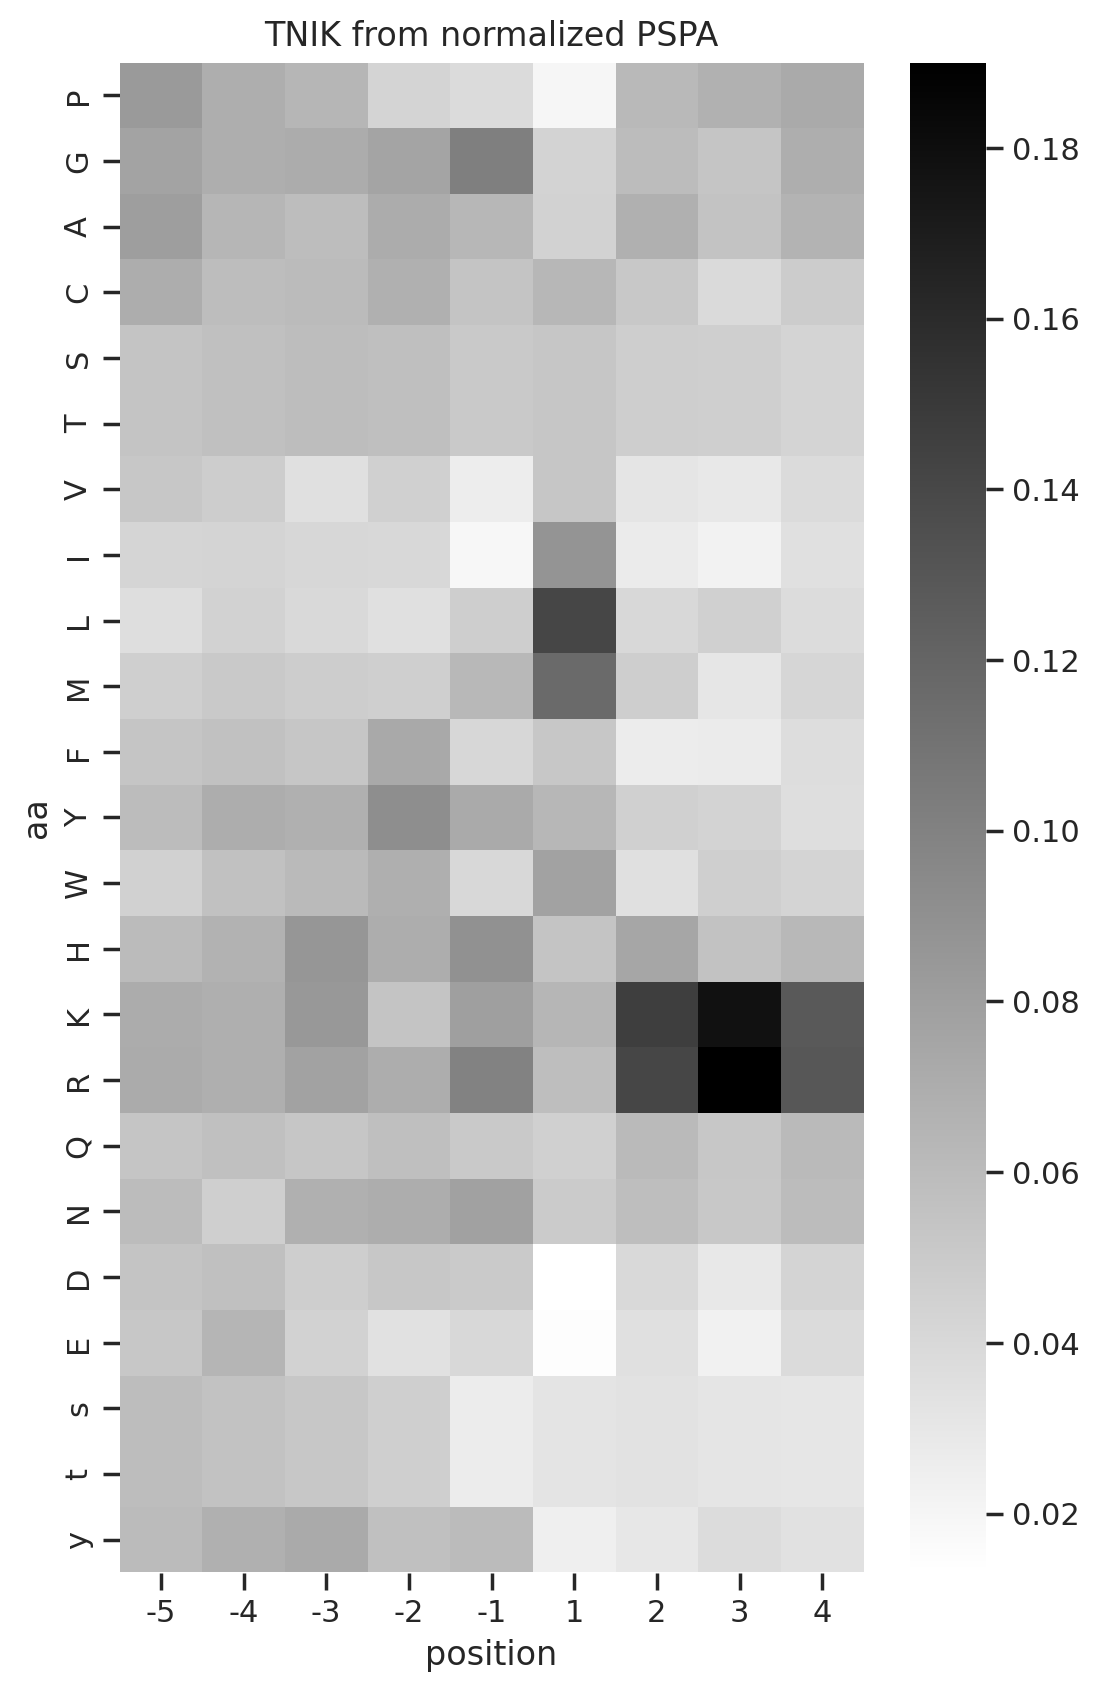

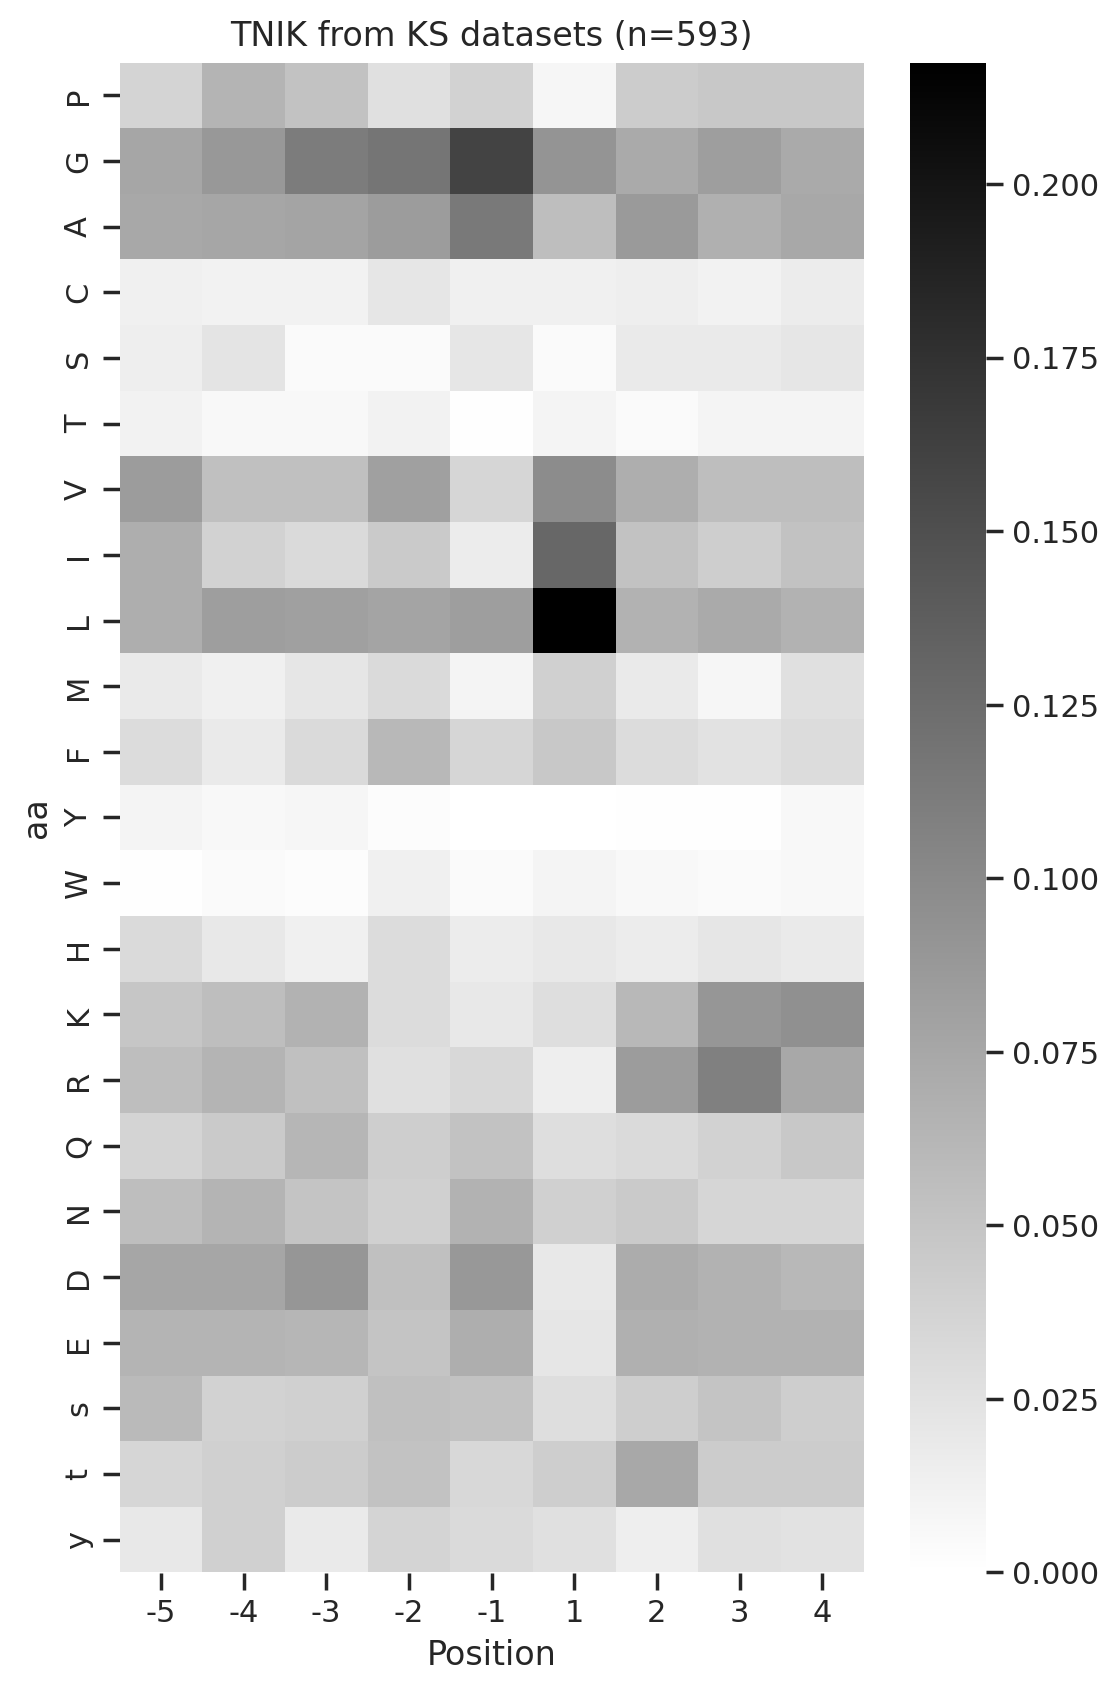

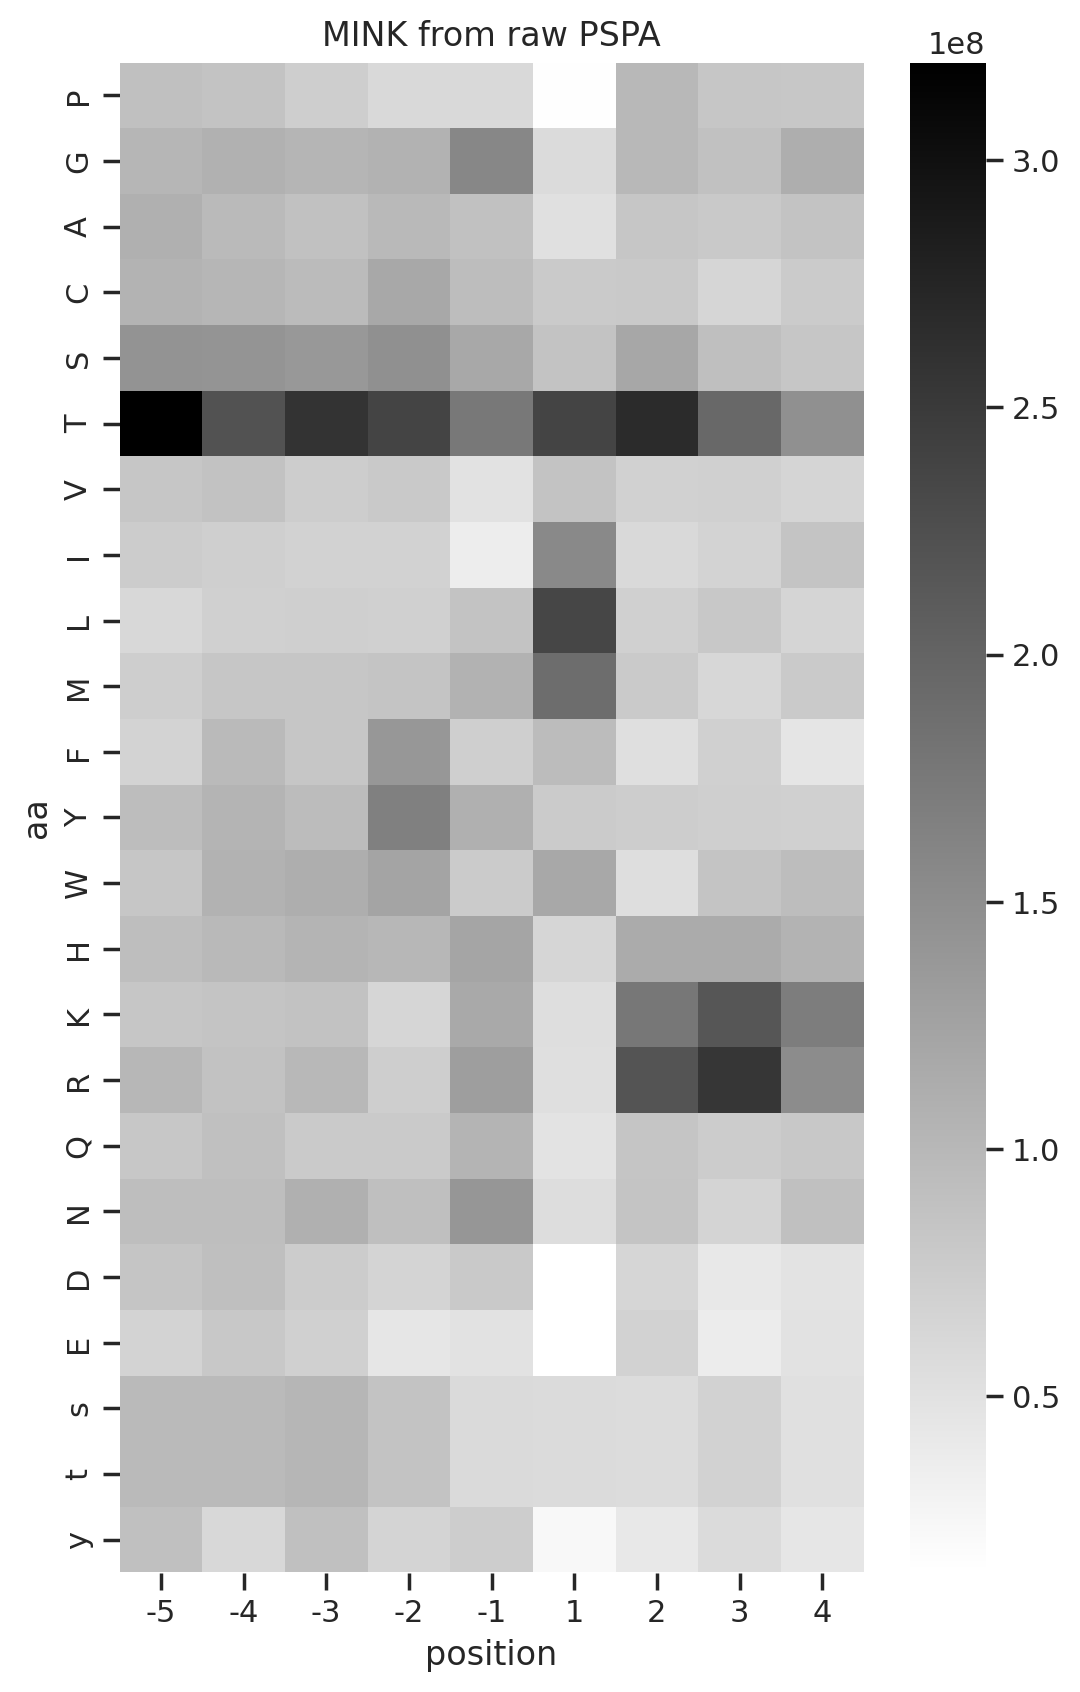

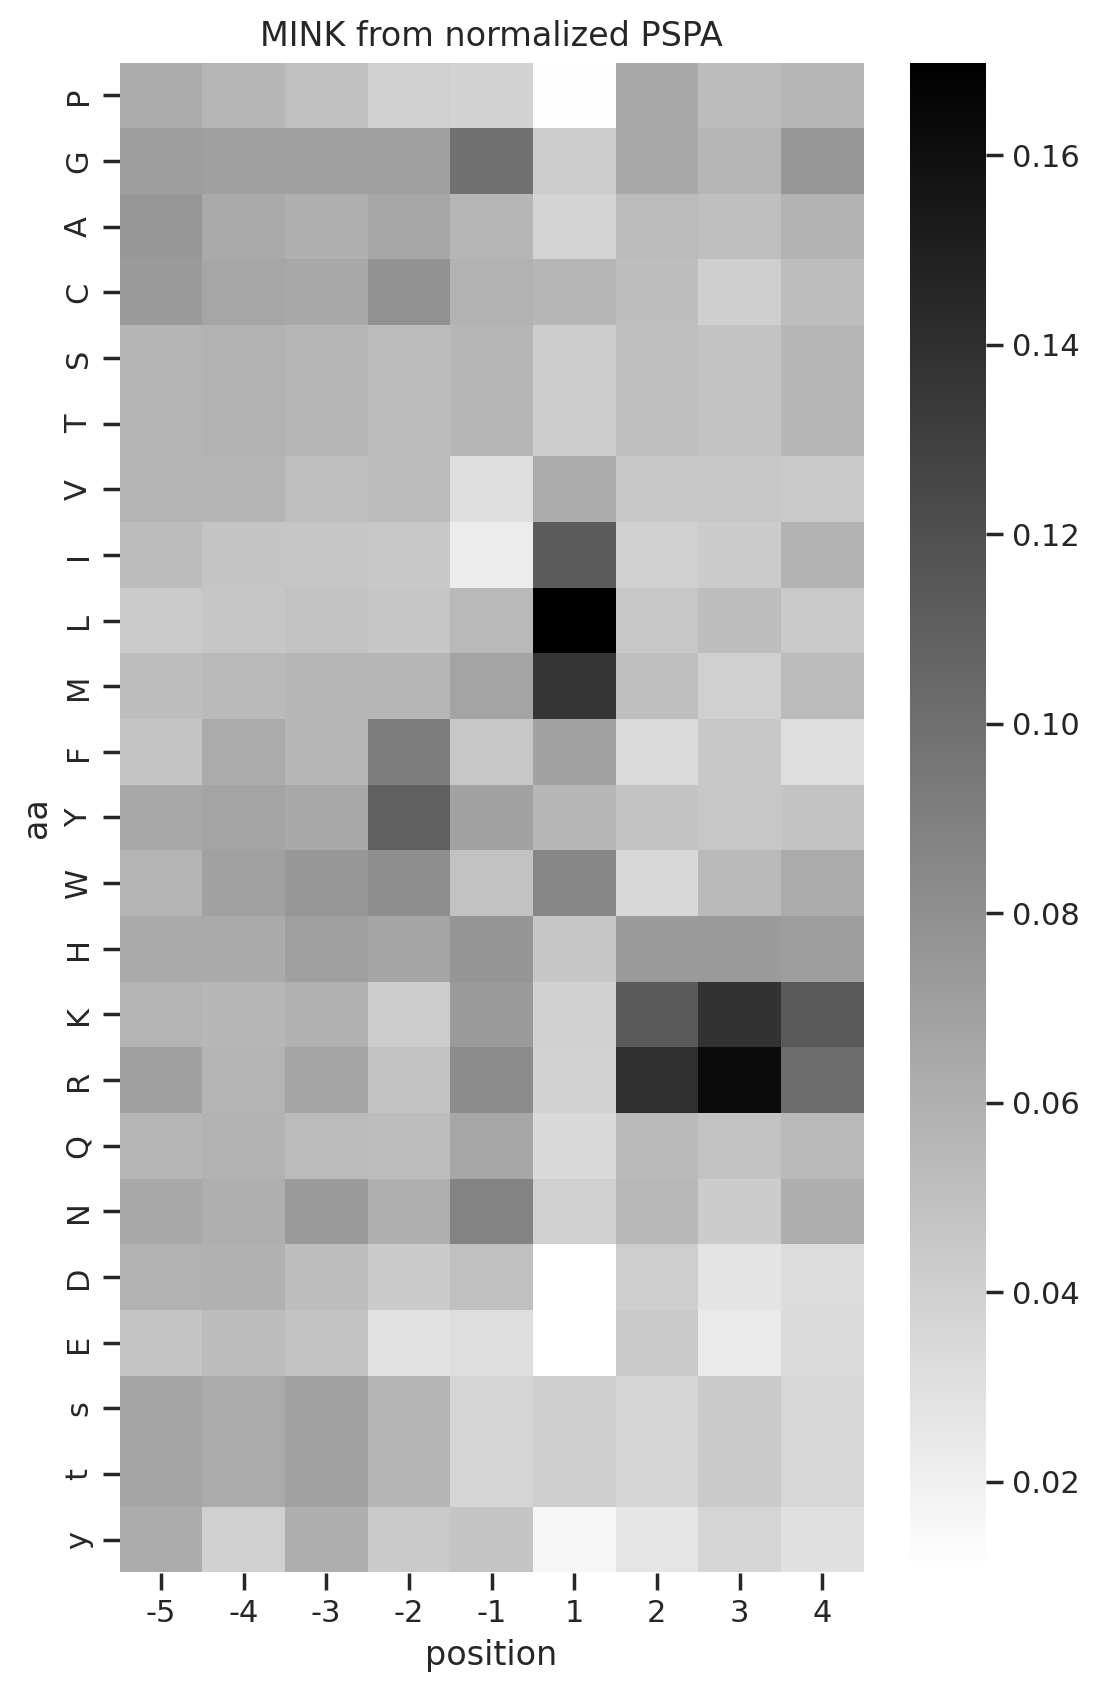

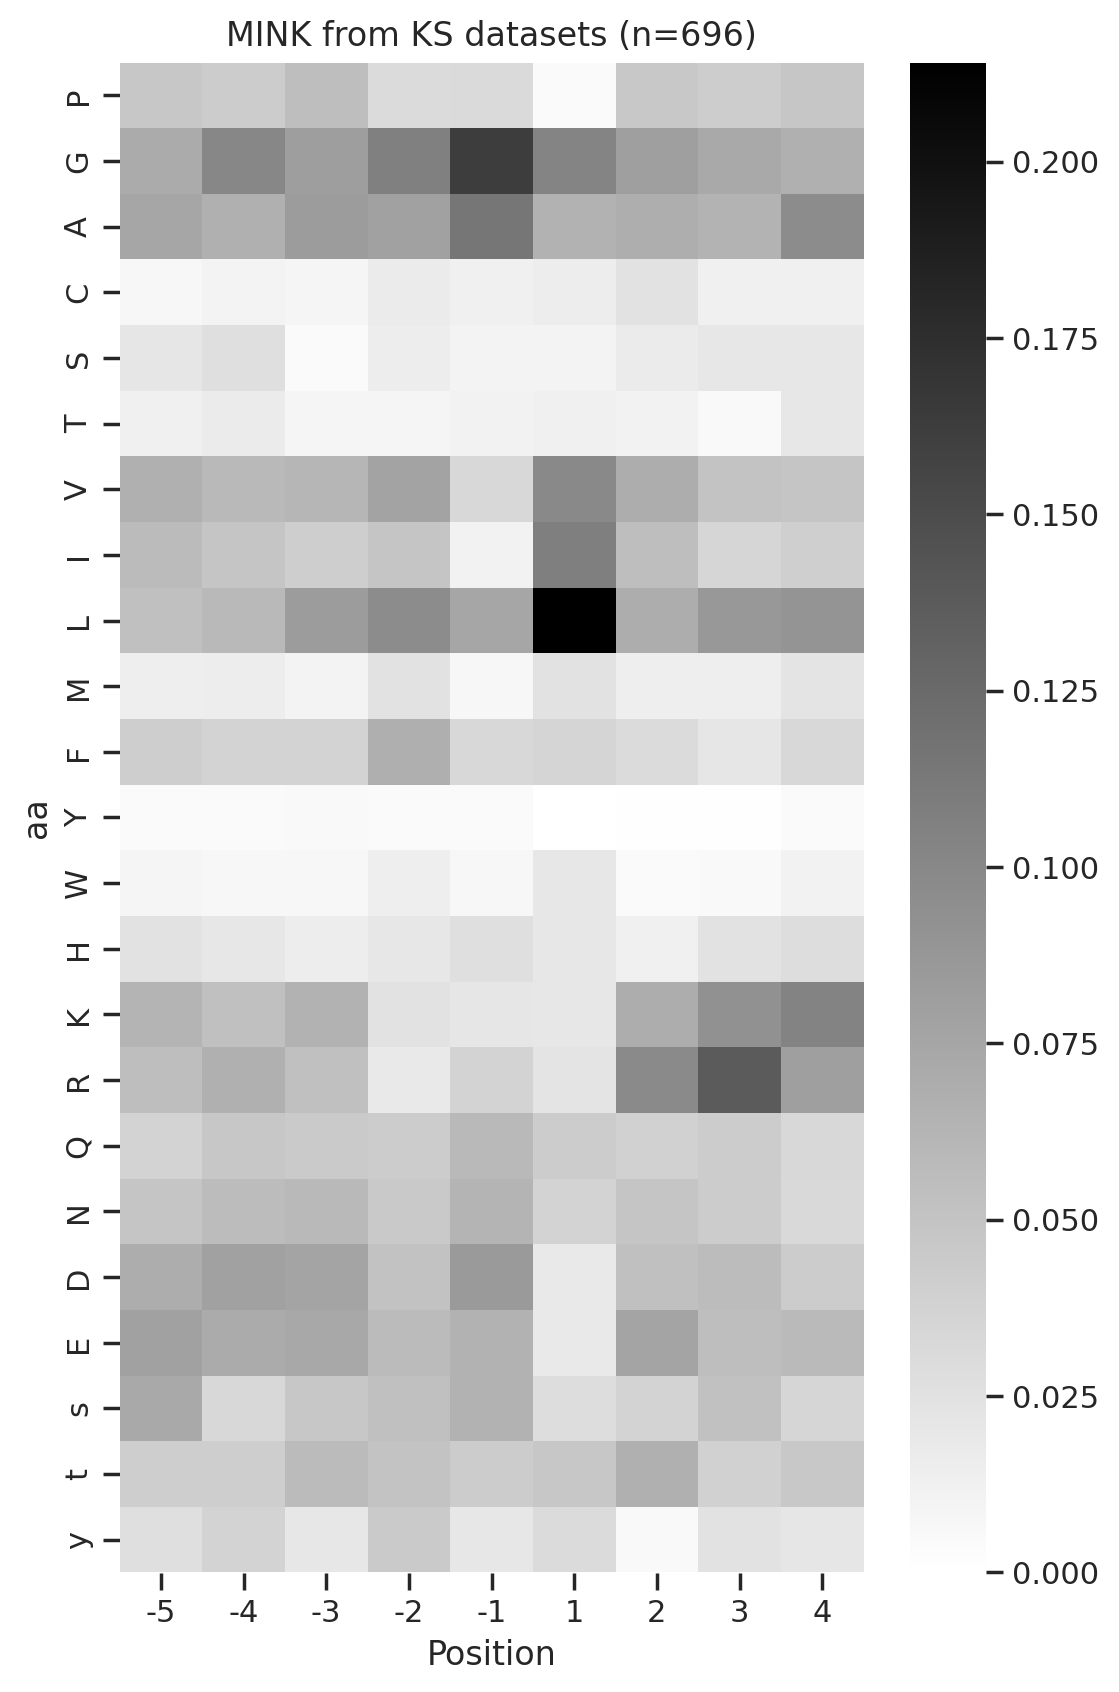

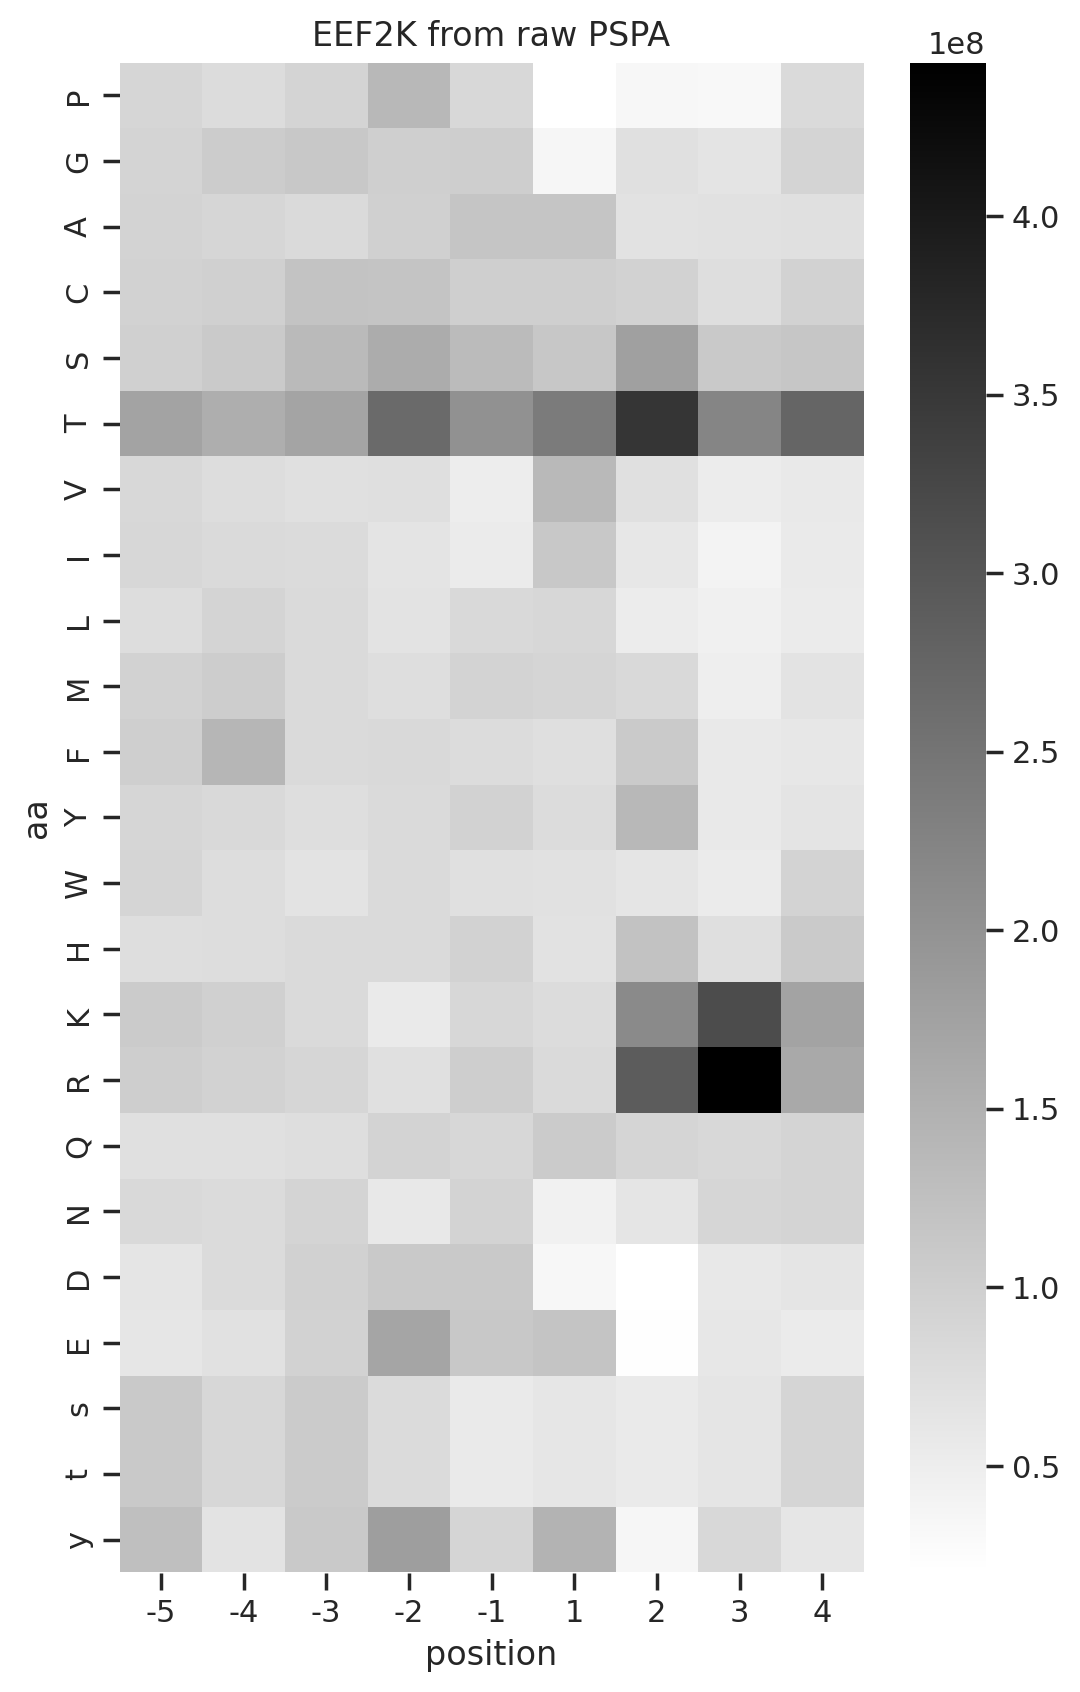

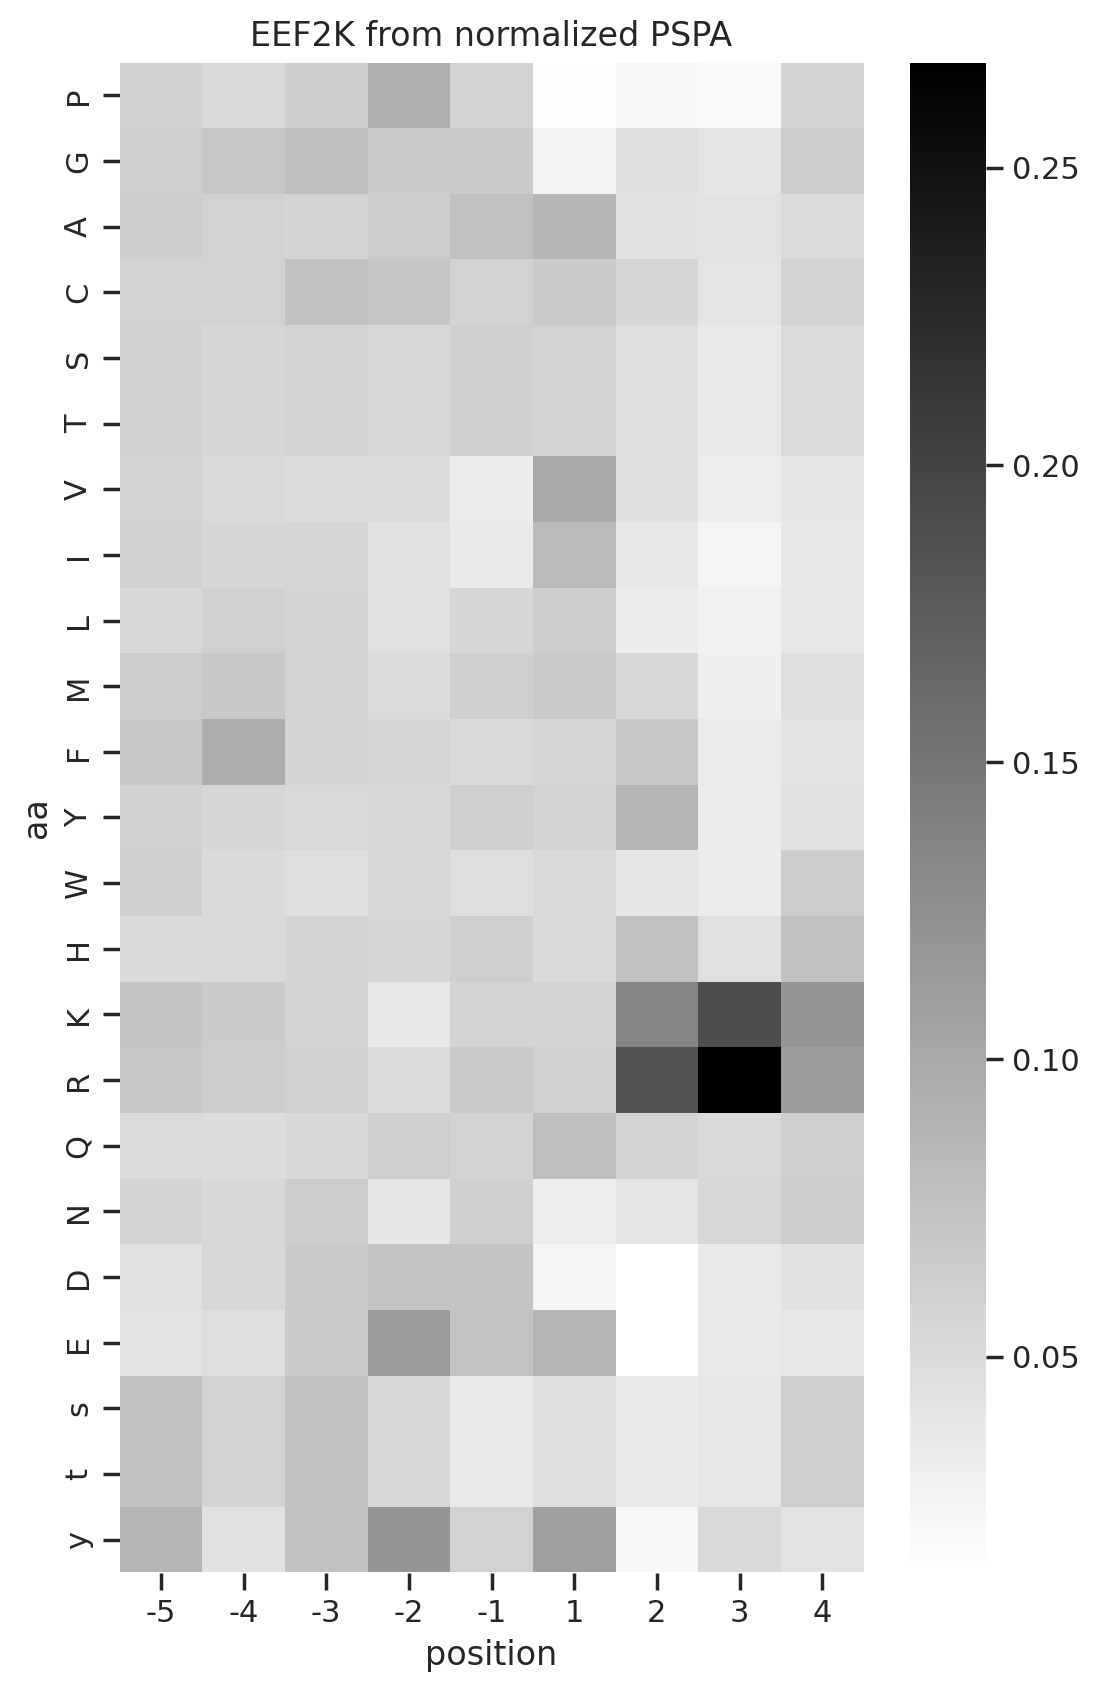

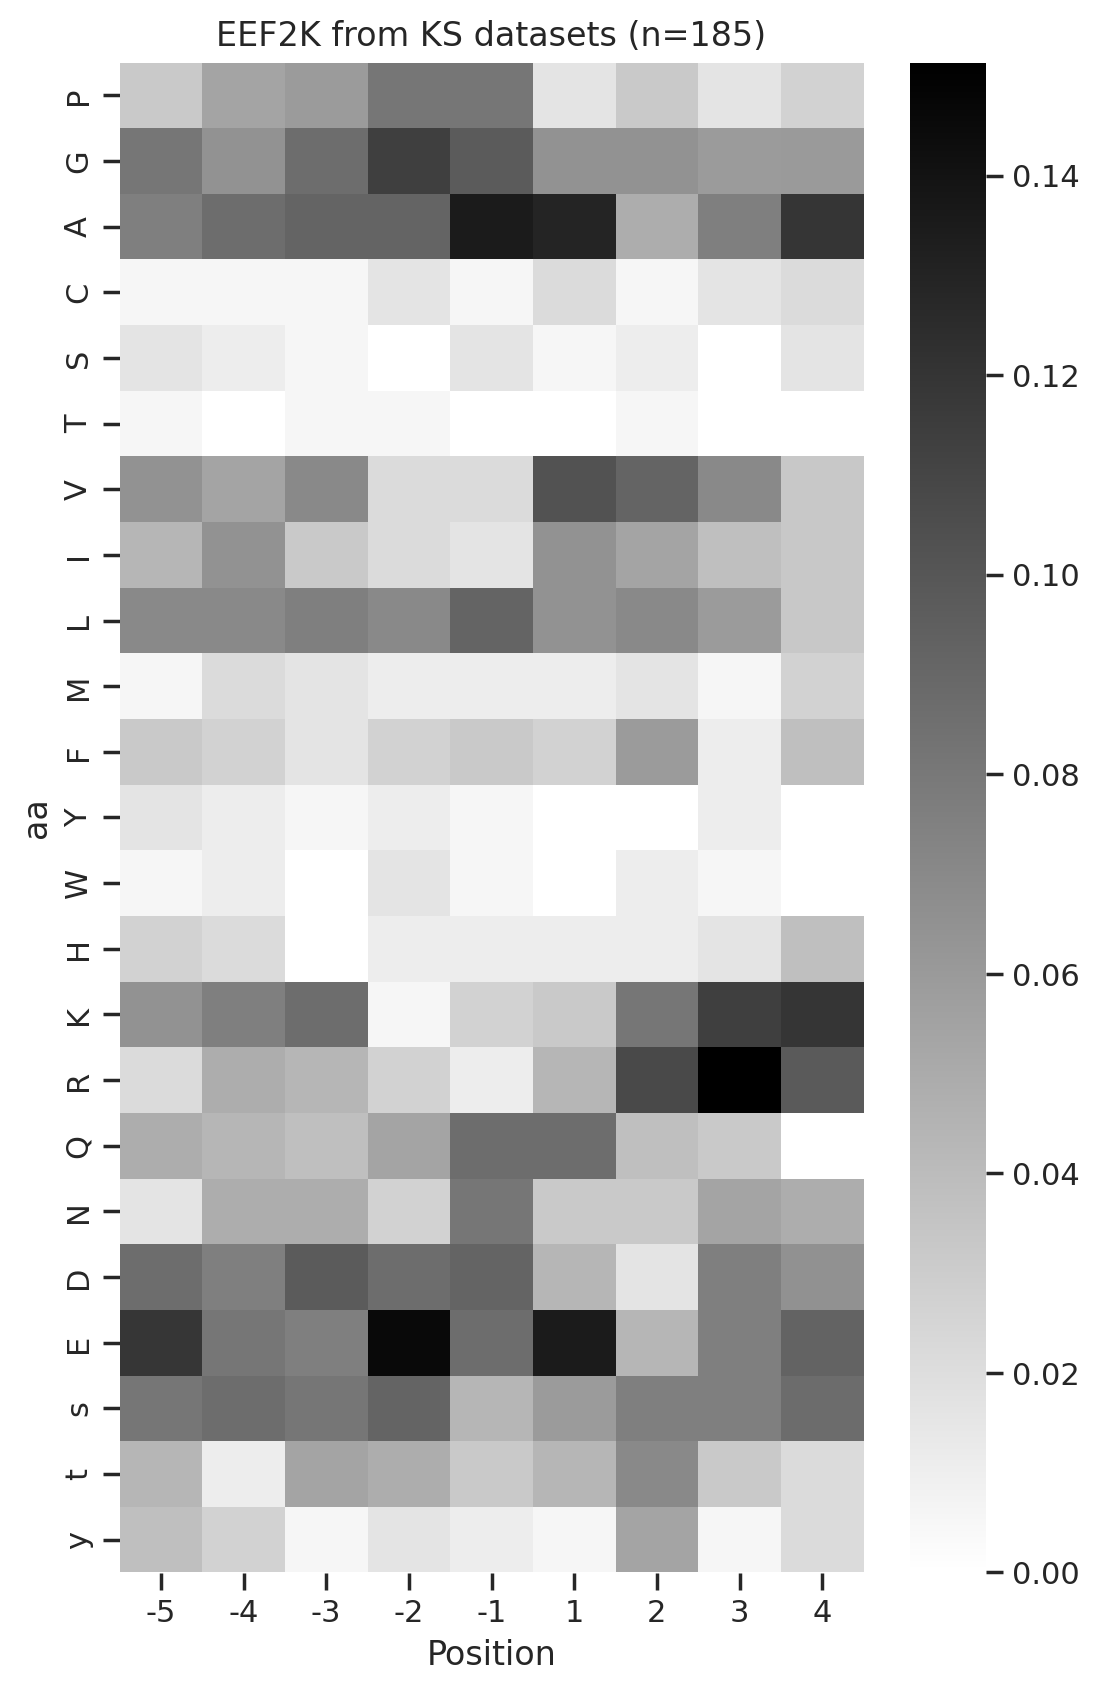

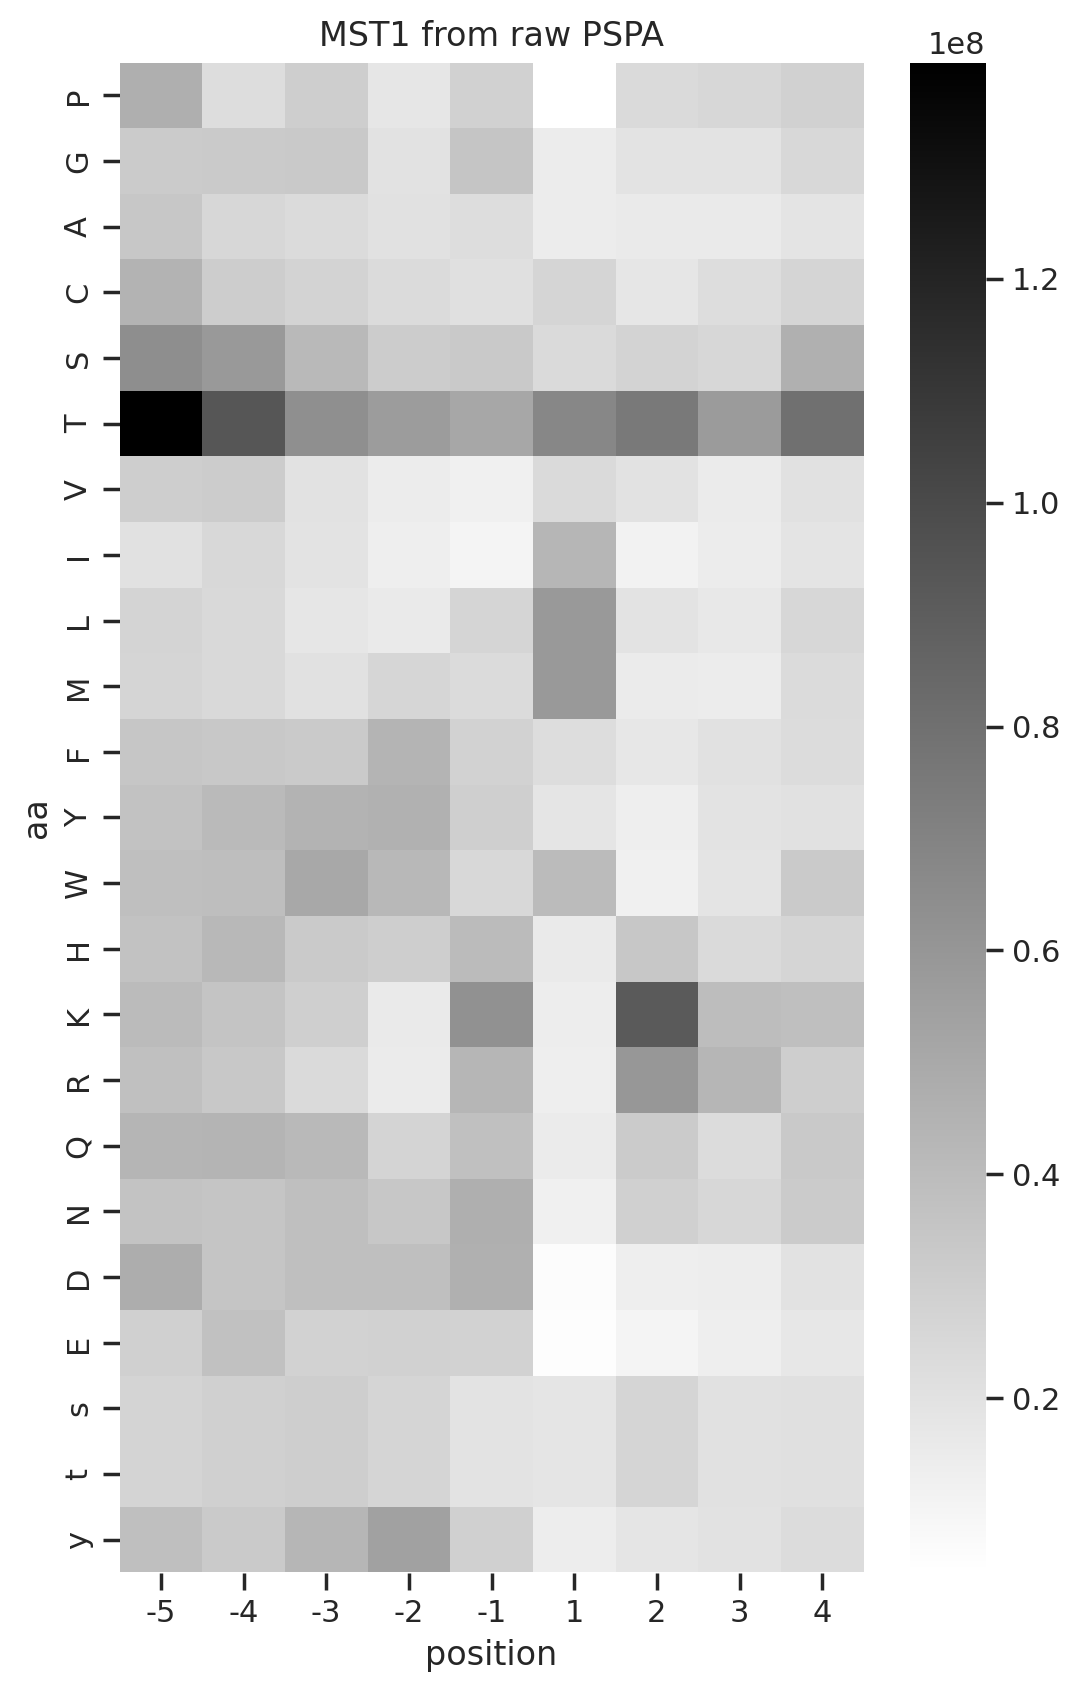

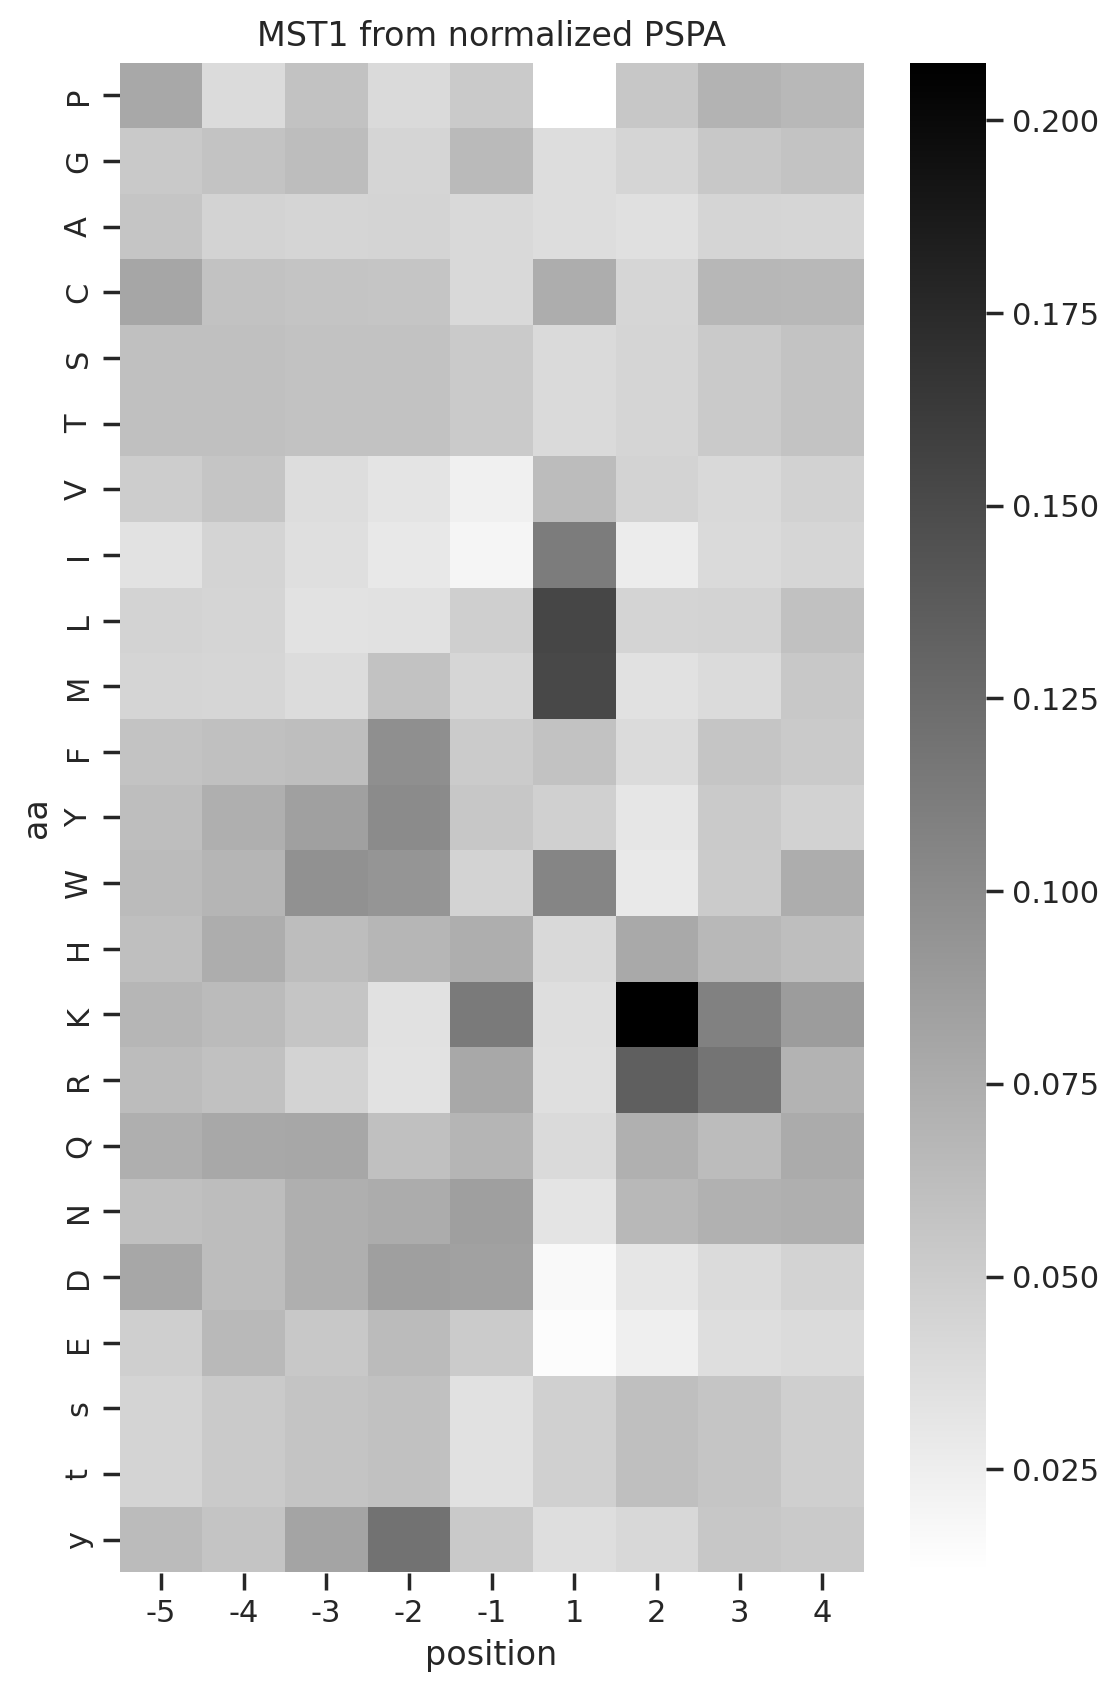

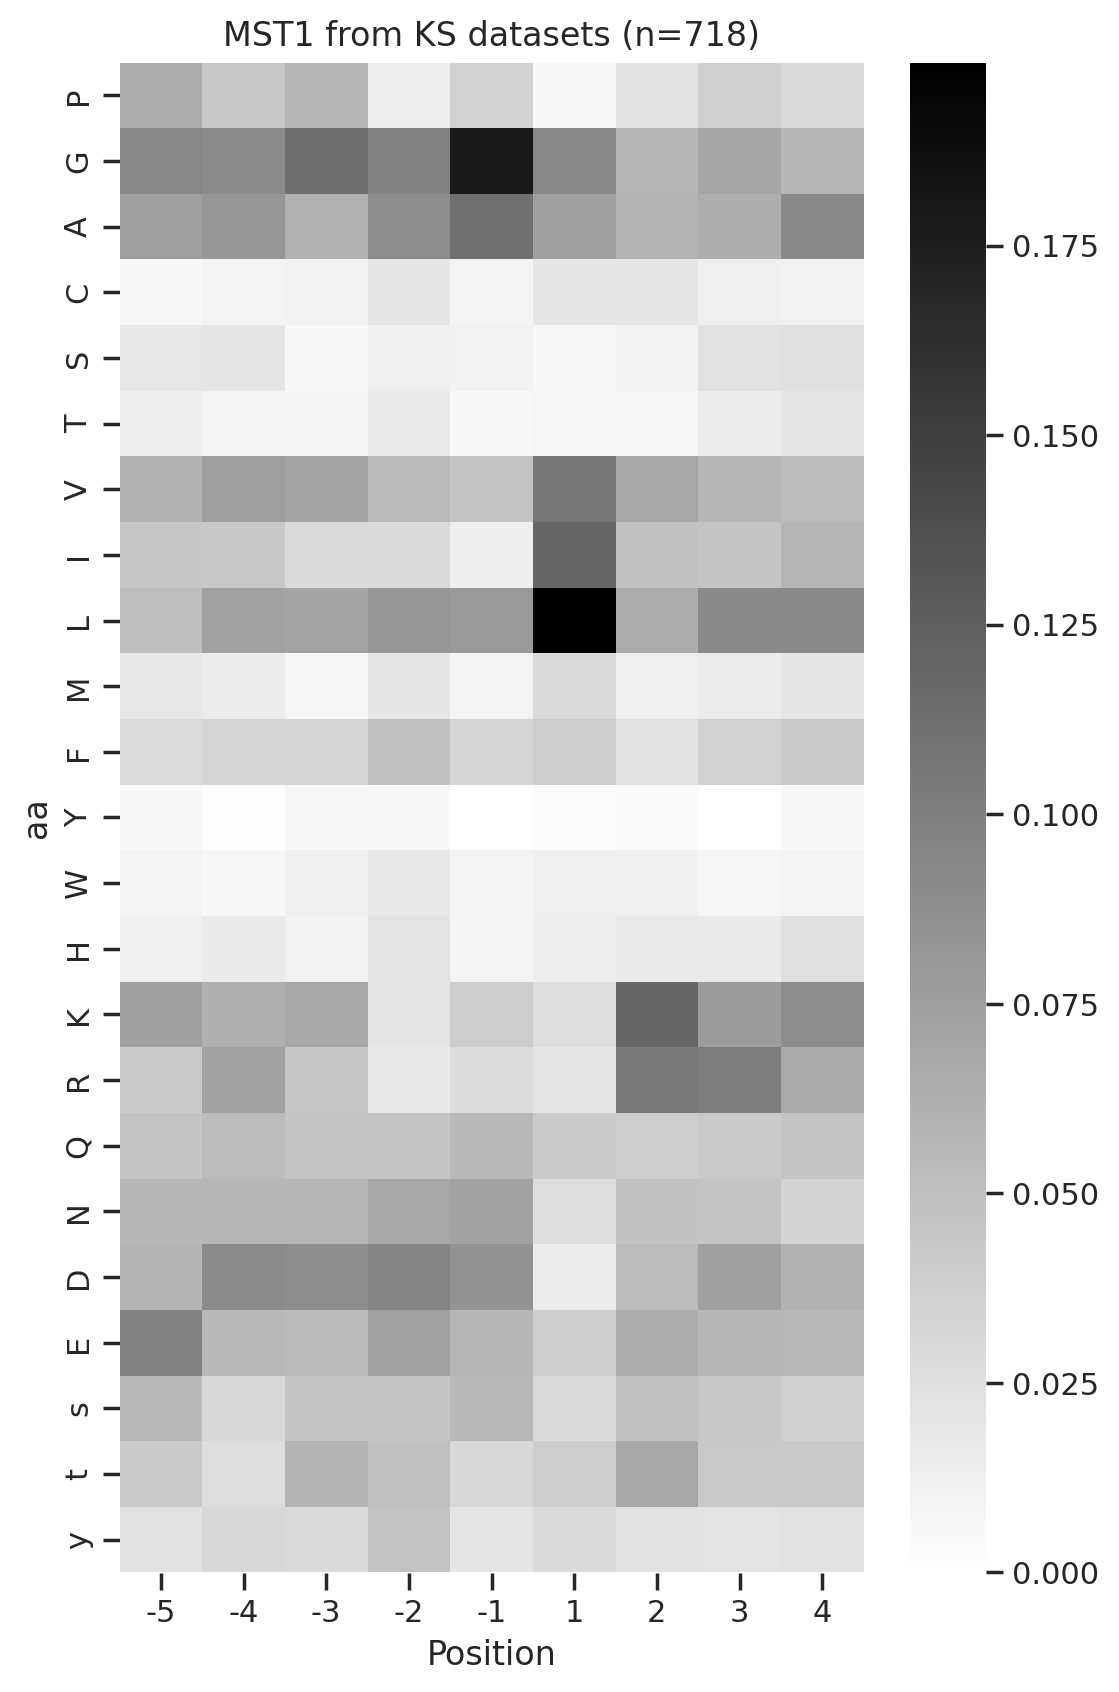

In [ ]:
for k in corr.sort_values('change_corr',ascending=False).kinase[:5]:
    
    df_k=df.query(f'kinase_paper == "{k}"')
    df_k = df_k.drop_duplicates(subset="SUB")
    
    paper, full = get_freq(df_k)

    raw_k = get_one_kinase(raw,k,drop_s=False).T
    raw_k = raw_k.reindex(index=aa_order_paper)
    
    norm_k = get_one_kinase(norm,k,drop_s=False).T
    norm_k = norm_k.reindex(index=aa_order_paper)
    
    plot_heatmap(raw_k,f'{k} from raw PSPA')
    plot_heatmap(norm_k,f'{k} from normalized PSPA')
    plot_heatmap(paper,f'{k} from KS datasets (n={len(df_k)})')

Calculate S and T ratio

In [ ]:
data = []
for k in overlap_cnt.index:

    # paper, full = get_freq(df,k)

    raw_k = get_one_kinase(raw,k,drop_s=False).T
    raw_k = raw_k.reindex(index=aa_order_paper)
    
    s_ratio = (raw_k.loc['S']/raw_k.sum()).median() #use median because it can better reflect the distribution of the data than the average
    t_ratio = (raw_k.loc['T']/raw_k.sum()).median()
    data.append([k,s_ratio,t_ratio])

In [ ]:
ST_ratio = pd.DataFrame(data,columns=['kinase','S_ratio','T_ratio'])

In [ ]:
corr = corr.merge(ST_ratio)

In [ ]:
corr.corr()

,corr_with_raw,count_unique,corr_with_norm,specificity,change_corr,S_ratio,T_ratio
corr_with_raw,1.000000,0.141216,0.968214,0.594262,-0.566374,0.171268,-0.445375
count_unique,0.141216,1.000000,0.199915,0.056954,0.128221,0.155907,0.001734
corr_with_norm,0.968214,0.199915,1.000000,0.515635,-0.342232,0.256669,-0.302619
specificity,0.594262,0.056954,0.515635,1.000000,-0.533407,-0.001163,-0.295673
change_corr,-0.566374,0.128221,-0.342232,-0.533407,1.000000,0.202328,0.675979
S_ratio,0.171268,0.155907,0.256669,-0.001163,0.202328,1.000000,-0.074444
T_ratio,-0.445375,0.001734,-0.302619,-0.295673,0.675979,-0.074444,1.000000


Check change_corr column in the correlation plot, it seems T ratio is highly correlated with change_corr

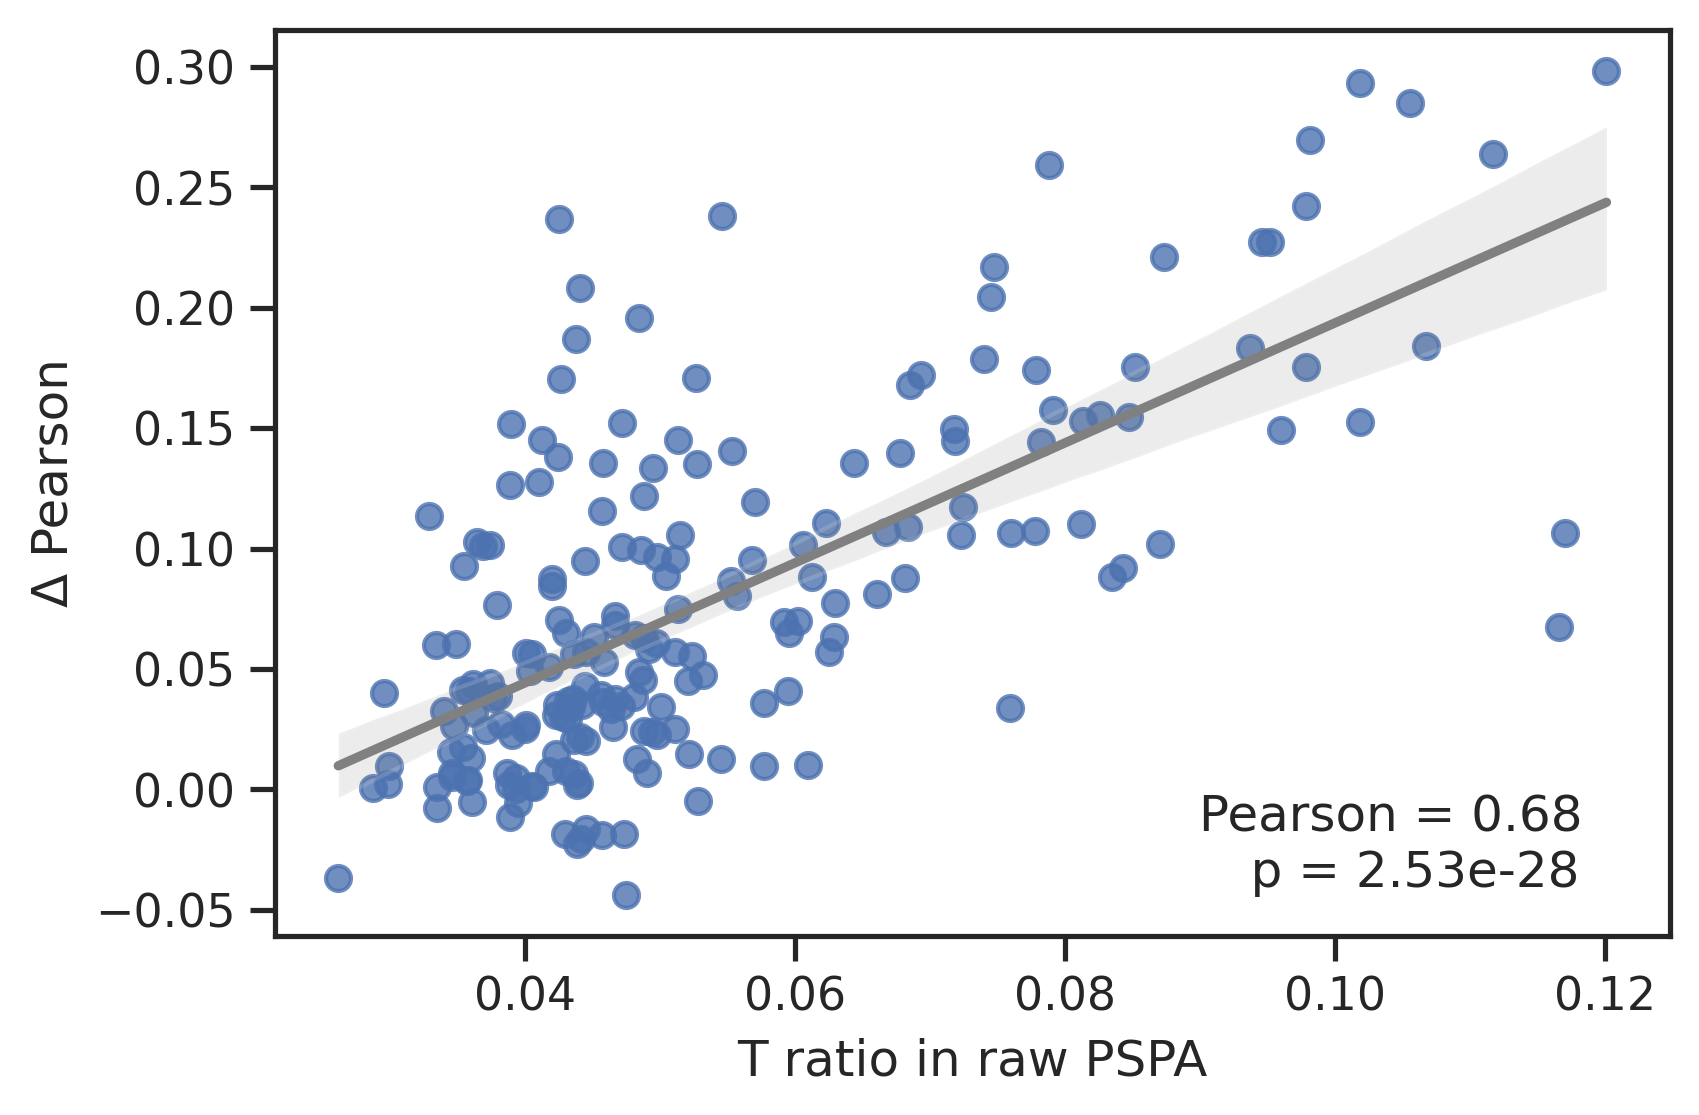

In [ ]:
plot_corr(y=corr.change_corr,x=corr.T_ratio)
plt.xlabel('T ratio in raw PSPA')
plt.ylabel('Δ Pearson');